<a href="https://colab.research.google.com/github/vedhapprakashni/uidai-data-hackathon/blob/main/uidai_hackathon.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# ========================================
# PHASE 1: Setup & Data Loading
# ========================================

# Install required packages
!pip install folium geopandas plotly scikit-learn seaborn pandas numpy matplotlib -q

# Import all required libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
from plotly.subplots import make_subplots
import warnings
warnings.filterwarnings('ignore')

# For ML
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.cluster import KMeans, DBSCAN
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import silhouette_score, davies_bouldin_score
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.metrics import classification_report, confusion_matrix
from scipy.cluster.hierarchy import dendrogram, linkage

# Set display options
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")

print("✅ All libraries imported successfully!")
print("=" * 60)

# Upload files
from google.colab import files
print("\n📁 Please upload your CSV files:")
print("   1. api_data_aadhar_enrolment_0_500000.csv")
print("   2. api_data_aadhar_demographic_500000_1000000.csv")
print("=" * 60)

uploaded = files.upload()


# Load the two enrollment datasets
print("\n📊 Loading datasets...")
df1 = pd.read_csv('api_data_aadhar_enrolment_0_500000.csv')
df2 = pd.read_csv('api_data_aadhar_demographic_500000_1000000.csv')

print(f"✅ Dataset 1 loaded: {df1.shape}")
print(f"✅ Dataset 2 loaded: {df2.shape}")

# Concatenate datasets
df = pd.concat([df1, df2], axis=0, ignore_index=True)
print(f"\n✅ Combined dataset: {df.shape}")
print("=" * 60)

# Display basic info
print("\n📋 Dataset Structure:")
print(df.head(10))
print("\n📋 Column Information:")
print(df.info())
print("\n📋 Basic Statistics:")
print(df.describe())

# Check data types
print("\n📋 Data Types:")
print(df.dtypes)

print("\n" + "=" * 60)
print("✅ PHASE 1 COMPLETE: Data loaded successfully!")
print("=" * 60)

✅ All libraries imported successfully!

📁 Please upload your CSV files:
   1. api_data_aadhar_enrolment_0_500000.csv
   2. api_data_aadhar_demographic_500000_1000000.csv


Saving api_data_aadhar_demographic_500000_1000000.csv to api_data_aadhar_demographic_500000_1000000.csv
Saving api_data_aadhar_enrolment_0_500000.csv to api_data_aadhar_enrolment_0_500000.csv

📊 Loading datasets...
✅ Dataset 1 loaded: (500000, 7)
✅ Dataset 2 loaded: (500000, 6)

✅ Combined dataset: (1000000, 9)

📋 Dataset Structure:
         date          state          district  pincode  age_0_5  age_5_17  \
0  02-03-2025      Meghalaya  East Khasi Hills   793121     11.0      61.0   
1  09-03-2025      Karnataka   Bengaluru Urban   560043     14.0      33.0   
2  09-03-2025  Uttar Pradesh      Kanpur Nagar   208001     29.0      82.0   
3  09-03-2025  Uttar Pradesh           Aligarh   202133     62.0      29.0   
4  09-03-2025      Karnataka   Bengaluru Urban   560016     14.0      16.0   
5  09-03-2025          Bihar         Sitamarhi   843331     20.0      49.0   
6  09-03-2025          Bihar         Sitamarhi   843330     23.0      24.0   
7  09-03-2025  Uttar Pradesh          Bah

In [2]:
# ========================================
# PHASE 2: Data Cleaning & Preprocessing
# ========================================

print("🧹 Starting Data Cleaning & Preprocessing...")
print("=" * 60)

# Create a copy for processing
df_clean = df.copy()

# Step 1: Check missing values
print("\n📊 Missing Values Analysis:")
missing_summary = pd.DataFrame({
    'Column': df_clean.columns,
    'Missing_Count': df_clean.isnull().sum().values,
    'Missing_Percentage': (df_clean.isnull().sum().values / len(df_clean) * 100).round(2)
})
print(missing_summary)

# Step 2: Check duplicates
duplicates = df_clean.duplicated().sum()
print(f"\n📊 Duplicate rows: {duplicates}")
if duplicates > 0:
    df_clean = df_clean.drop_duplicates()
    print(f"✅ Removed {duplicates} duplicate rows")

# Step 3: Handle missing values
print("\n🔧 Handling Missing Values...")

# Drop rows with missing pincodes (critical for geographic analysis)
initial_rows = len(df_clean)
df_clean = df_clean.dropna(subset=['pincode'])
print(f"   Dropped {initial_rows - len(df_clean)} rows with missing pincodes")

# Drop rows with missing state or district
df_clean = df_clean.dropna(subset=['state', 'district'])

# Fill missing age group values with 0 (assuming no enrollment)
age_columns = ['age_0_5', 'age_5_17', 'age_18_greater']
for col in age_columns:
    if df_clean[col].isnull().sum() > 0:
        df_clean[col] = df_clean[col].fillna(0)

print(f"✅ Final dataset size: {df_clean.shape}")

# Step 4: Data type conversions
print("\n🔧 Converting Data Types...")

# Convert date column
df_clean['date'] = pd.to_datetime(df_clean['date'], errors='coerce')

# Convert pincode to string (to preserve leading zeros)
df_clean['pincode'] = df_clean['pincode'].astype(str).str.strip()

# Ensure age columns are numeric
for col in age_columns:
    df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce').fillna(0)

# Clean state and district names
df_clean['state'] = df_clean['state'].str.strip()
df_clean['district'] = df_clean['district'].str.strip()

print("✅ Data types converted successfully")

# Step 5: Create derived features
print("\n🔧 Creating Derived Features...")

# Total enrollments
df_clean['total_enrollments'] = (
    df_clean['age_0_5'] +
    df_clean['age_5_17'] +
    df_clean['age_18_greater']
)

# Enrollment rates by age group (percentage)
df_clean['child_enrollment_rate'] = np.where(
    df_clean['total_enrollments'] > 0,
    (df_clean['age_0_5'] / df_clean['total_enrollments'] * 100),
    0
)

df_clean['youth_enrollment_rate'] = np.where(
    df_clean['total_enrollments'] > 0,
    (df_clean['age_5_17'] / df_clean['total_enrollments'] * 100),
    0
)

df_clean['adult_enrollment_rate'] = np.where(
    df_clean['total_enrollments'] > 0,
    (df_clean['age_18_greater'] / df_clean['total_enrollments'] * 100),
    0
)

# Extract temporal features
df_clean['enrollment_year'] = df_clean['date'].dt.year
df_clean['enrollment_month'] = df_clean['date'].dt.month
df_clean['enrollment_day'] = df_clean['date'].dt.day
df_clean['enrollment_quarter'] = df_clean['date'].dt.quarter
df_clean['enrollment_day_of_week'] = df_clean['date'].dt.dayofweek

# Pincode-based features
df_clean['pincode_first_2'] = df_clean['pincode'].str[:2]
df_clean['pincode_first_3'] = df_clean['pincode'].str[:3]

# Identify metro cities (common metro pincodes)
metro_prefixes = ['110', '400', '560', '600', '700', '500']  # Delhi, Mumbai, Bangalore, Chennai, Kolkata, Hyderabad
df_clean['is_metro'] = df_clean['pincode_first_3'].isin(metro_prefixes).astype(int)

# Urban/Rural classification (rough proxy based on pincode patterns)
# This is a simplified heuristic - actual classification would need external data
df_clean['is_urban'] = df_clean['is_metro']  # Starting with metro as urban

print("✅ Derived features created:")
print(f"   - total_enrollments")
print(f"   - child/youth/adult_enrollment_rate")
print(f"   - enrollment_year, enrollment_month, enrollment_quarter")
print(f"   - pincode_first_2, pincode_first_3")
print(f"   - is_metro, is_urban")

# Step 6: Data quality checks
print("\n📊 Data Quality Checks:")
print(f"Total enrollments range: {df_clean['total_enrollments'].min():.0f} - {df_clean['total_enrollments'].max():.0f}")
print(f"Date range: {df_clean['date'].min()} to {df_clean['date'].max()}")
print(f"Unique states: {df_clean['state'].nunique()}")
print(f"Unique districts: {df_clean['district'].nunique()}")
print(f"Unique pincodes: {df_clean['pincode'].nunique()}")

# Display sample of processed data
print("\n📋 Sample of Processed Data:")
print(df_clean.head(10))

print("\n" + "=" * 60)
print("✅ PHASE 2 COMPLETE: Data cleaned and preprocessed!")
print("=" * 60)

🧹 Starting Data Cleaning & Preprocessing...

📊 Missing Values Analysis:
           Column  Missing_Count  Missing_Percentage
0            date              0                 0.0
1           state              0                 0.0
2        district              0                 0.0
3         pincode              0                 0.0
4         age_0_5         500000                50.0
5        age_5_17         500000                50.0
6  age_18_greater         500000                50.0
7   demo_age_5_17         500000                50.0
8    demo_age_17_         500000                50.0

📊 Duplicate rows: 6036
✅ Removed 6036 duplicate rows

🔧 Handling Missing Values...
   Dropped 0 rows with missing pincodes
✅ Final dataset size: (993964, 9)

🔧 Converting Data Types...
✅ Data types converted successfully

🔧 Creating Derived Features...
✅ Derived features created:
   - total_enrollments
   - child/youth/adult_enrollment_rate
   - enrollment_year, enrollment_month, enrollment_qua

In [3]:
# ========================================
# PHASE 3: Multi-Level Aggregation
# ========================================

print("📊 Creating Aggregated Datasets at Multiple Geographic Levels...")
print("=" * 60)

# LEVEL 1: PINCODE-LEVEL AGGREGATION
print("\n📍 Level 1: Pincode-Level Aggregation...")

pincode_agg = df_clean.groupby(['pincode', 'state', 'district']).agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrollments': 'sum',
    'child_enrollment_rate': 'mean',
    'youth_enrollment_rate': 'mean',
    'adult_enrollment_rate': 'mean',
    'is_metro': 'first',
    'is_urban': 'first',
    'date': ['min', 'max', 'count']
}).reset_index()

# Flatten column names
pincode_agg.columns = [
    'pincode', 'state', 'district',
    'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'total_enrollments', 'avg_child_rate', 'avg_youth_rate', 'avg_adult_rate',
    'is_metro', 'is_urban',
    'first_enrollment_date', 'last_enrollment_date', 'enrollment_events'
]

# Calculate enrollment duration
pincode_agg['enrollment_duration_days'] = (
    pincode_agg['last_enrollment_date'] - pincode_agg['first_enrollment_date']
).dt.days

# Calculate enrollment velocity (enrollments per day)
pincode_agg['enrollment_velocity'] = np.where(
    pincode_agg['enrollment_duration_days'] > 0,
    pincode_agg['total_enrollments'] / pincode_agg['enrollment_duration_days'],
    pincode_agg['total_enrollments']
)

print(f"✅ Pincode-level dataset: {pincode_agg.shape}")
print(f"   Unique pincodes: {len(pincode_agg)}")

# LEVEL 2: DISTRICT-LEVEL AGGREGATION
print("\n🏙️  Level 2: District-Level Aggregation...")

district_agg = df_clean.groupby(['state', 'district']).agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrollments': 'sum',
    'pincode': 'nunique',
    'is_metro': 'sum',
    'date': 'count'
}).reset_index()

district_agg.columns = [
    'state', 'district',
    'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'total_enrollments', 'unique_pincodes', 'metro_pincodes', 'enrollment_events'
]

# Calculate rates
district_agg['child_rate'] = (
    district_agg['total_age_0_5'] / district_agg['total_enrollments'] * 100
).round(2)

district_agg['youth_rate'] = (
    district_agg['total_age_5_17'] / district_agg['total_enrollments'] * 100
).round(2)

district_agg['adult_rate'] = (
    district_agg['total_age_18_greater'] / district_agg['total_enrollments'] * 100
).round(2)

# Enrollment density (enrollments per pincode)
district_agg['enrollment_density'] = (
    district_agg['total_enrollments'] / district_agg['unique_pincodes']
).round(2)

print(f"✅ District-level dataset: {district_agg.shape}")
print(f"   Unique districts: {len(district_agg)}")

# LEVEL 3: STATE-LEVEL AGGREGATION
print("\n🗺️  Level 3: State-Level Aggregation...")

state_agg = df_clean.groupby('state').agg({
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'total_enrollments': 'sum',
    'district': 'nunique',
    'pincode': 'nunique',
    'is_metro': 'sum',
    'date': 'count'
}).reset_index()

state_agg.columns = [
    'state',
    'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'total_enrollments', 'unique_districts', 'unique_pincodes',
    'metro_pincodes', 'enrollment_events'
]

# Calculate rates
state_agg['child_rate'] = (
    state_agg['total_age_0_5'] / state_agg['total_enrollments'] * 100
).round(2)

state_agg['youth_rate'] = (
    state_agg['total_age_5_17'] / state_agg['total_enrollments'] * 100
).round(2)

state_agg['adult_rate'] = (
    state_agg['total_age_18_greater'] / state_agg['total_enrollments'] * 100
).round(2)

# Sort by total enrollments
state_agg = state_agg.sort_values('total_enrollments', ascending=False)

print(f"✅ State-level dataset: {state_agg.shape}")
print(f"   Unique states: {len(state_agg)}")

# Display summaries
print("\n" + "=" * 60)
print("📊 AGGREGATION SUMMARIES:")
print("=" * 60)

print("\n🏆 Top 10 States by Enrollment:")
print(state_agg[['state', 'total_enrollments', 'unique_districts', 'unique_pincodes']].head(10))

print("\n📍 Sample Pincode-Level Data:")
print(pincode_agg.head(10))

print("\n🏙️  Sample District-Level Data:")
print(district_agg.head(10))

# Save aggregated datasets
pincode_agg.to_csv('pincode_aggregated.csv', index=False)
district_agg.to_csv('district_aggregated.csv', index=False)
state_agg.to_csv('state_aggregated.csv', index=False)

print("\n✅ Aggregated datasets saved as CSV files")

print("\n" + "=" * 60)
print("✅ PHASE 3 COMPLETE: Multi-level aggregation done!")
print("=" * 60)

📊 Creating Aggregated Datasets at Multiple Geographic Levels...

📍 Level 1: Pincode-Level Aggregation...
✅ Pincode-level dataset: (30359, 17)
   Unique pincodes: 30359

🏙️  Level 2: District-Level Aggregation...
✅ District-level dataset: (1095, 13)
   Unique districts: 1095

🗺️  Level 3: State-Level Aggregation...
✅ State-level dataset: (63, 12)
   Unique states: 63

📊 AGGREGATION SUMMARIES:

🏆 Top 10 States by Enrollment:
             state  total_enrollments  unique_districts  unique_pincodes
49   Uttar Pradesh           663768.0                90             1755
7            Bihar           387515.0                48              915
31  Madhya Pradesh           276085.0                61              791
32     Maharashtra           220535.0                53             1602
56     West Bengal           218621.0                65             1355
43       Rajasthan           204529.0                45              986
18         Gujarat           192525.0                40       

📊 Starting Univariate Analysis...

📈 1. Enrollment Distribution Analysis...


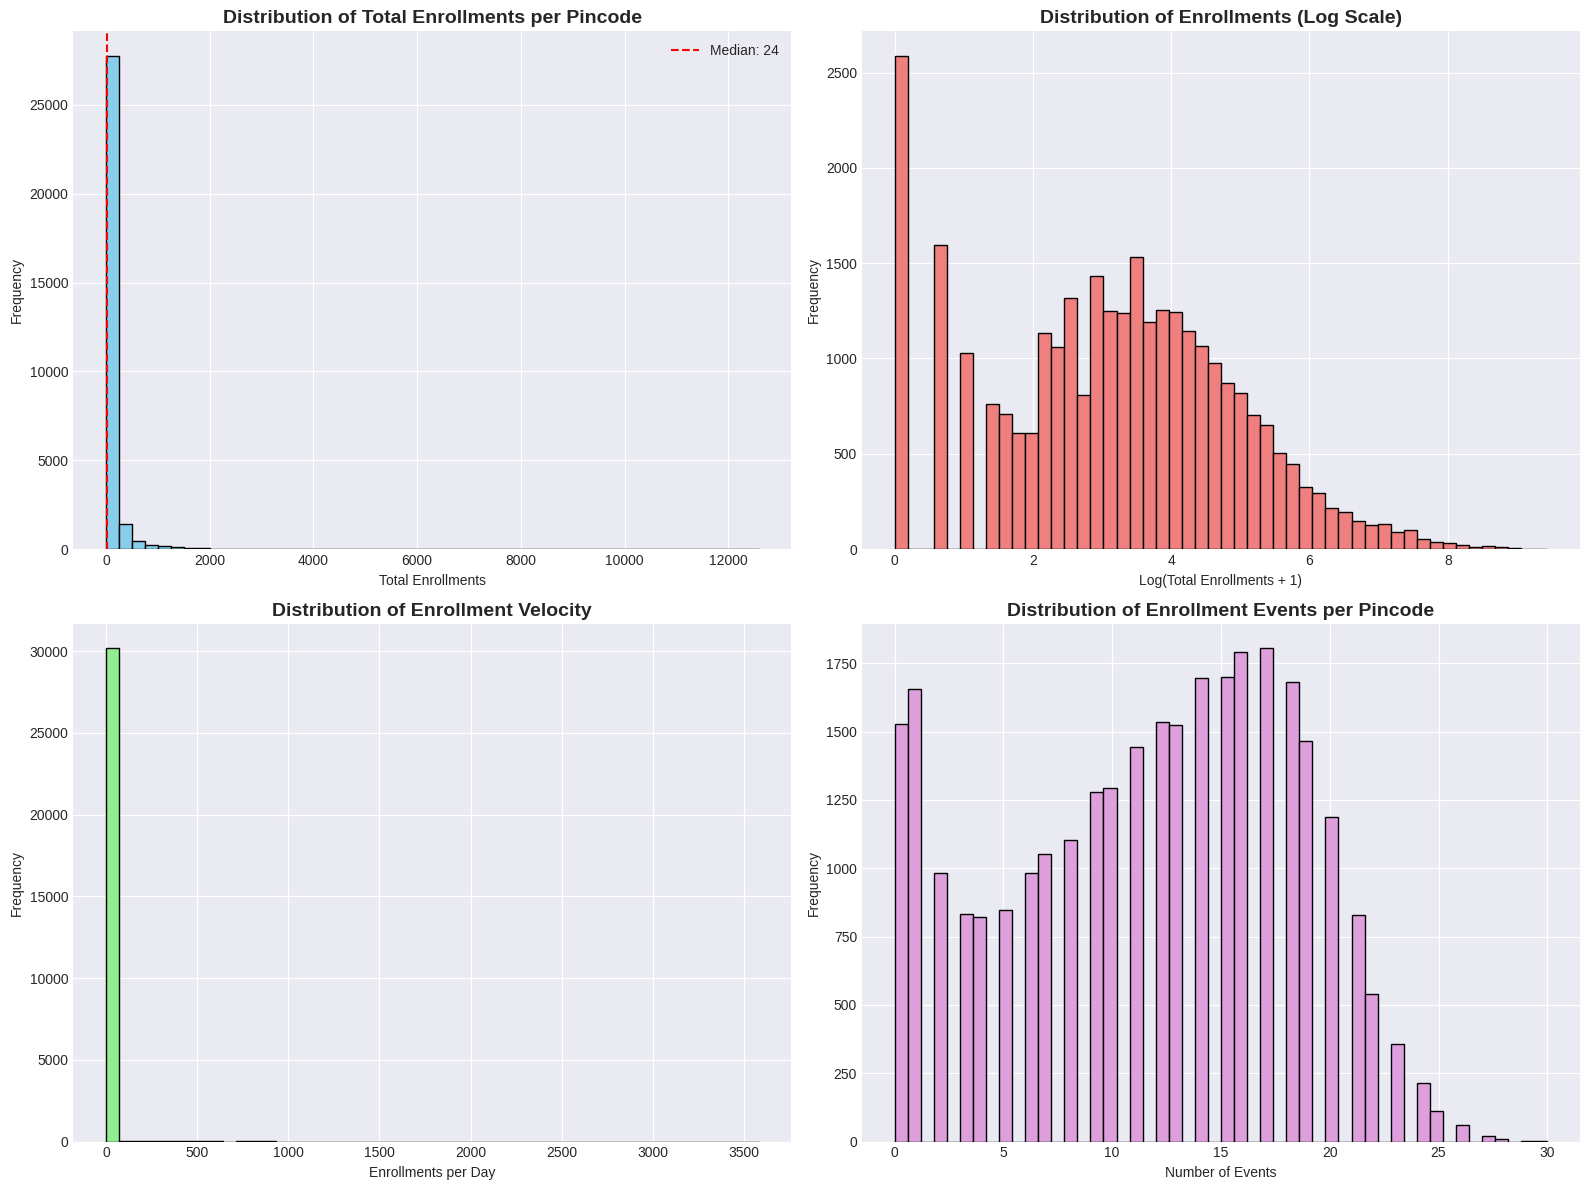

<Figure size 1600x800 with 0 Axes>

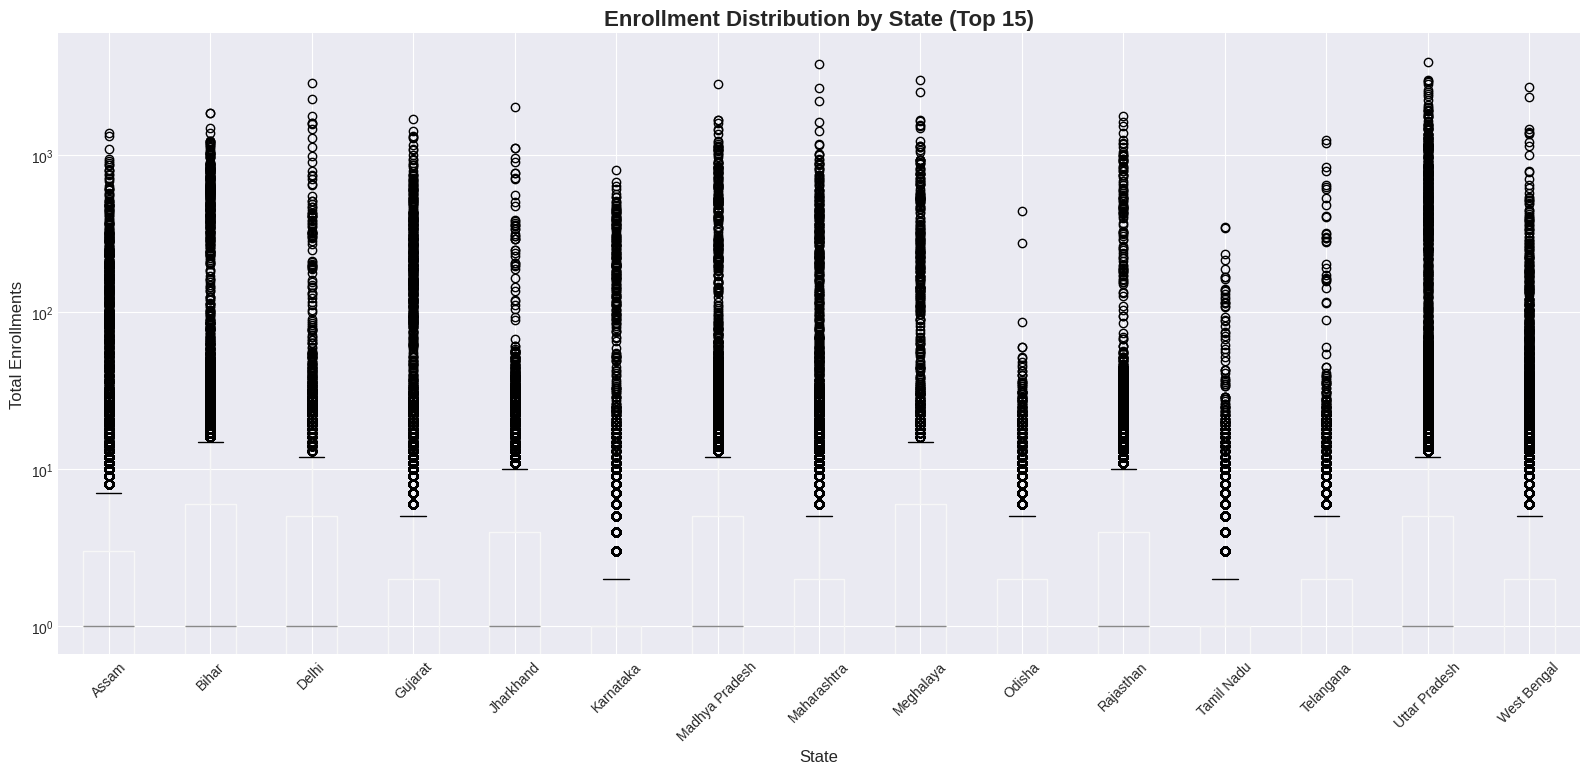

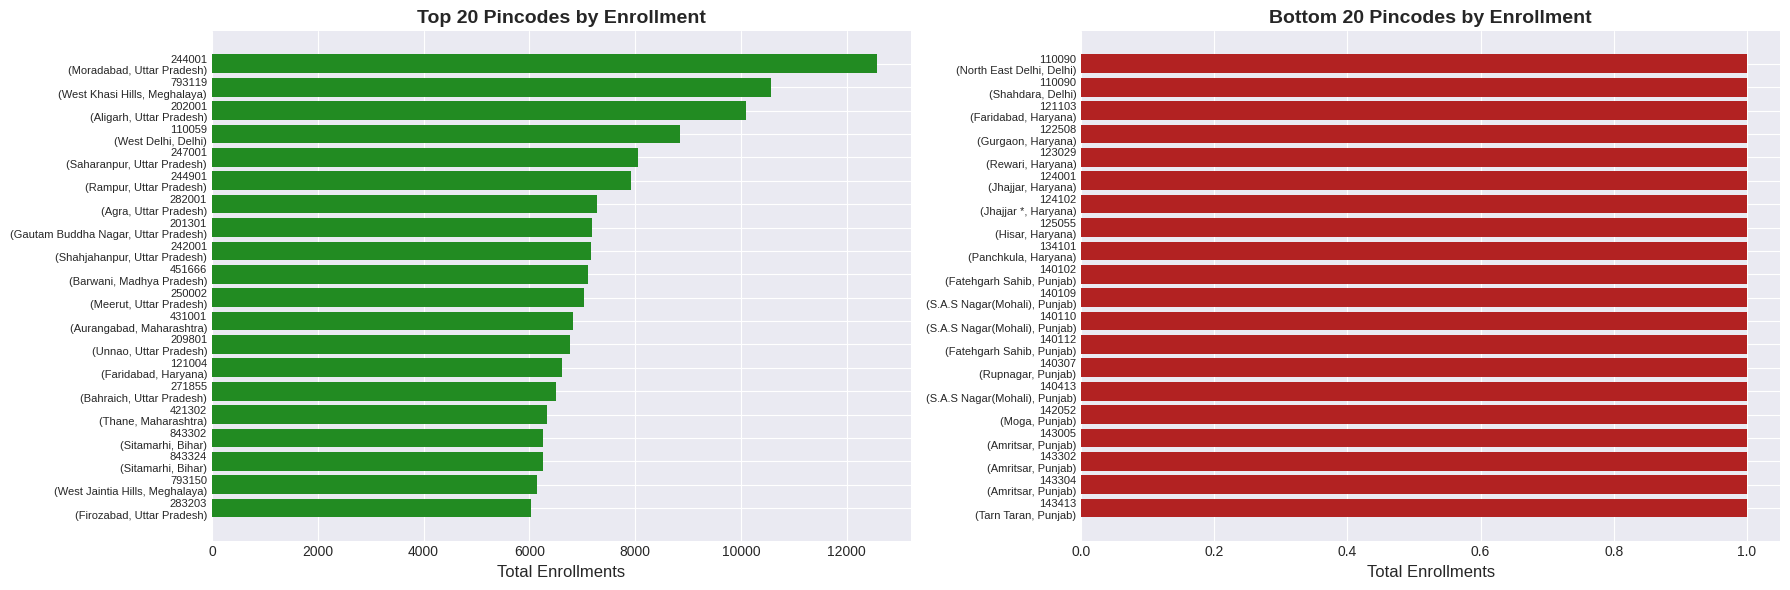

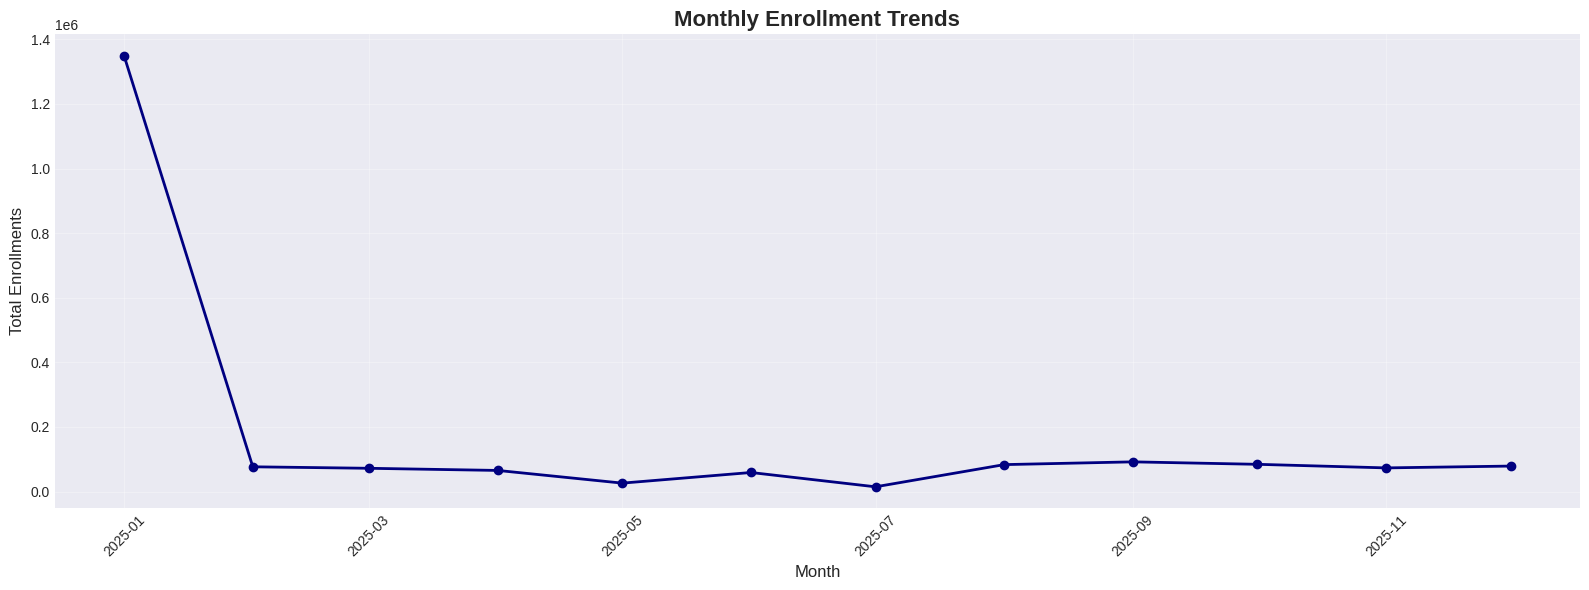


🗺️  2. Geographic Coverage Analysis...

📊 Coverage Metrics:
   Zero enrollment pincodes: 2587
   Low enrollment pincodes (< 10th percentile): 2587
   Total pincodes: 30359


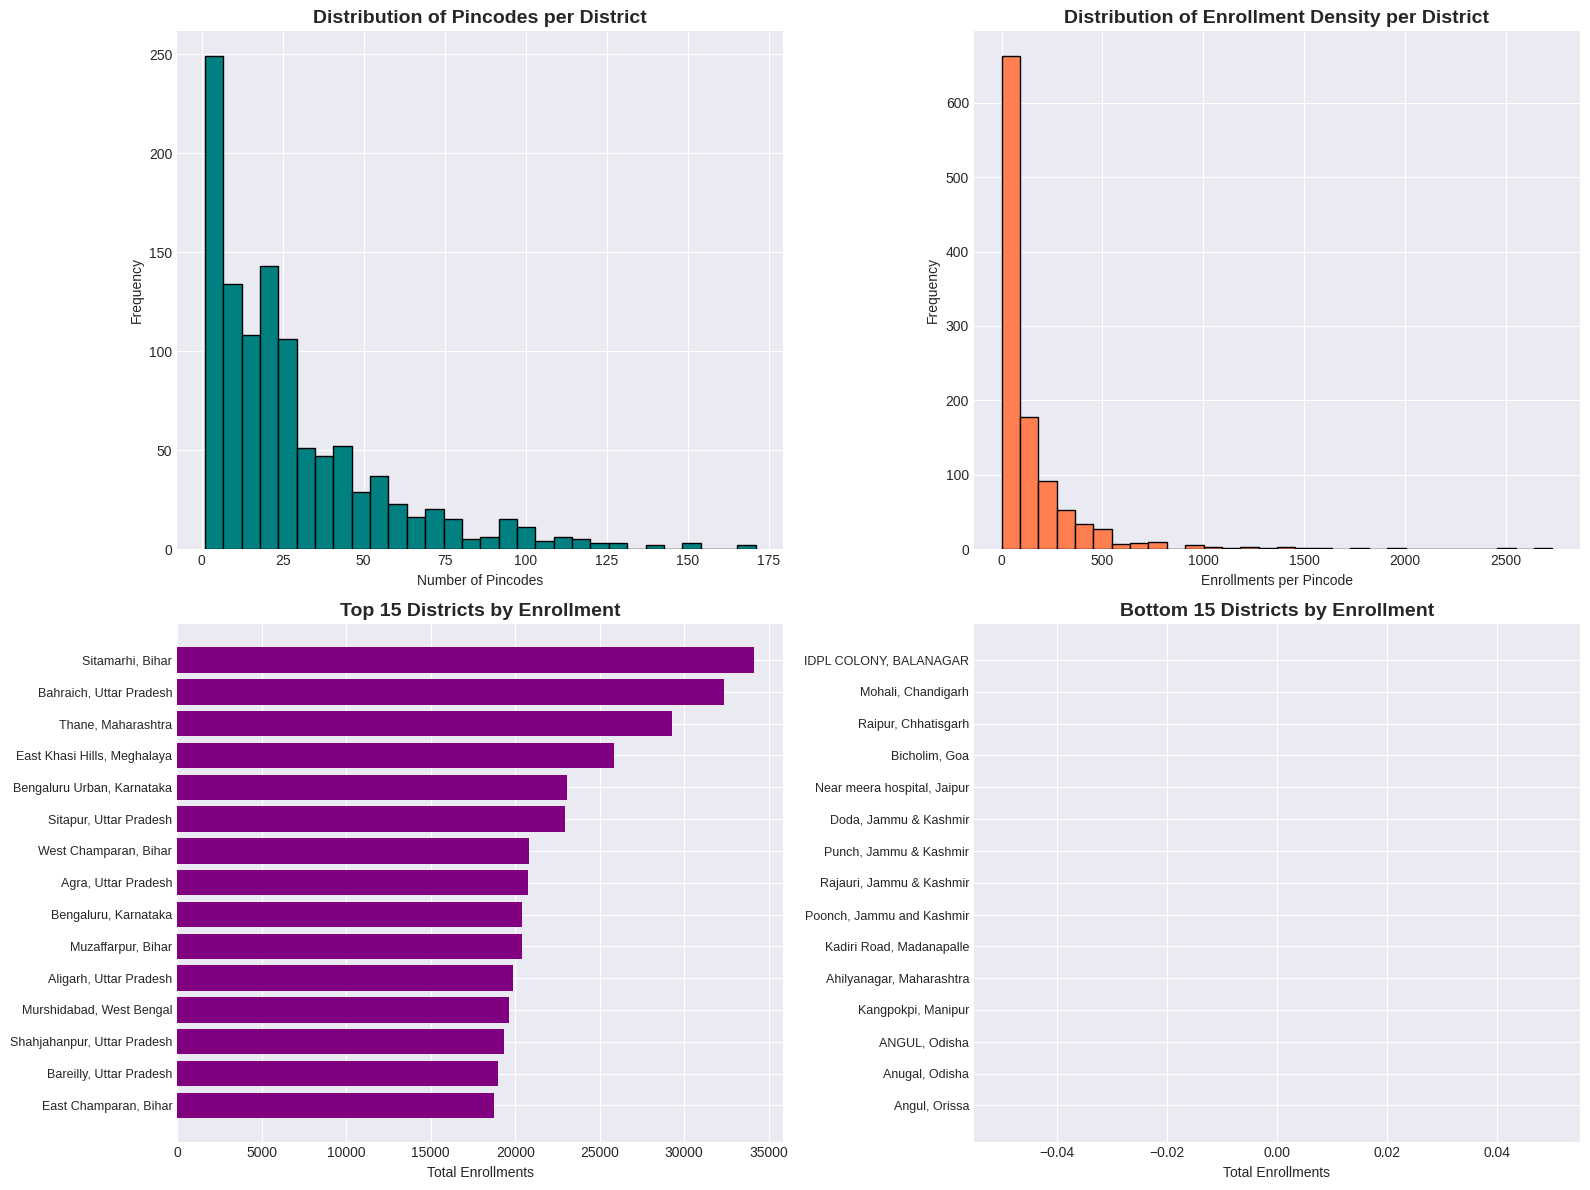


👥 3. Age Group Analysis...


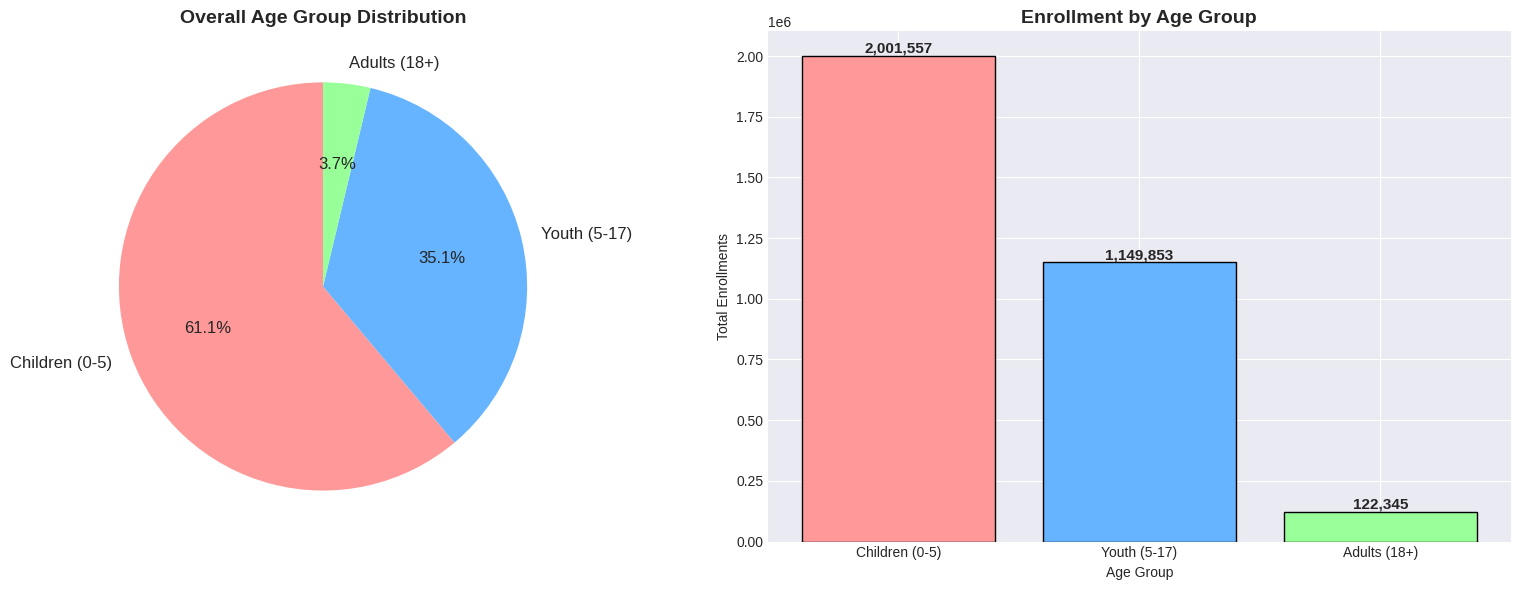

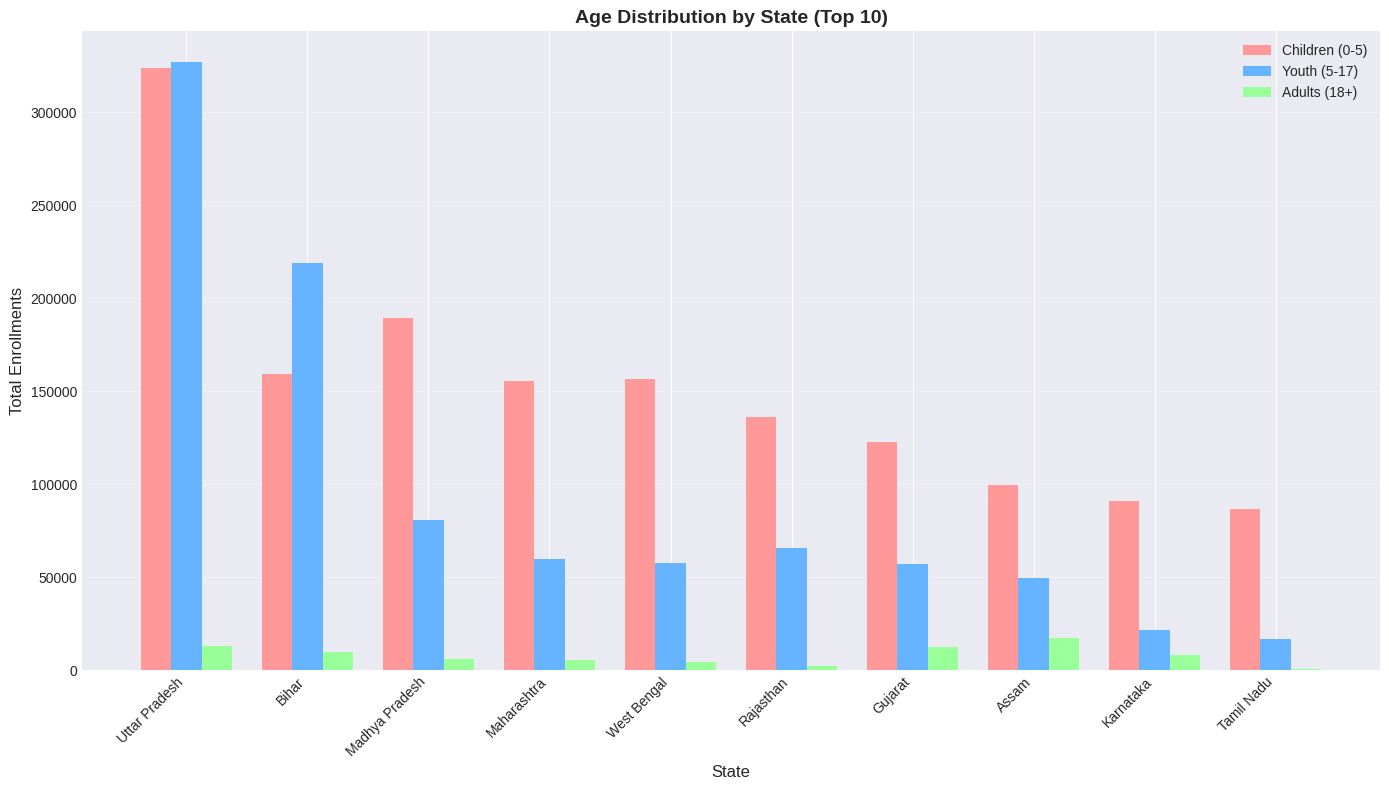

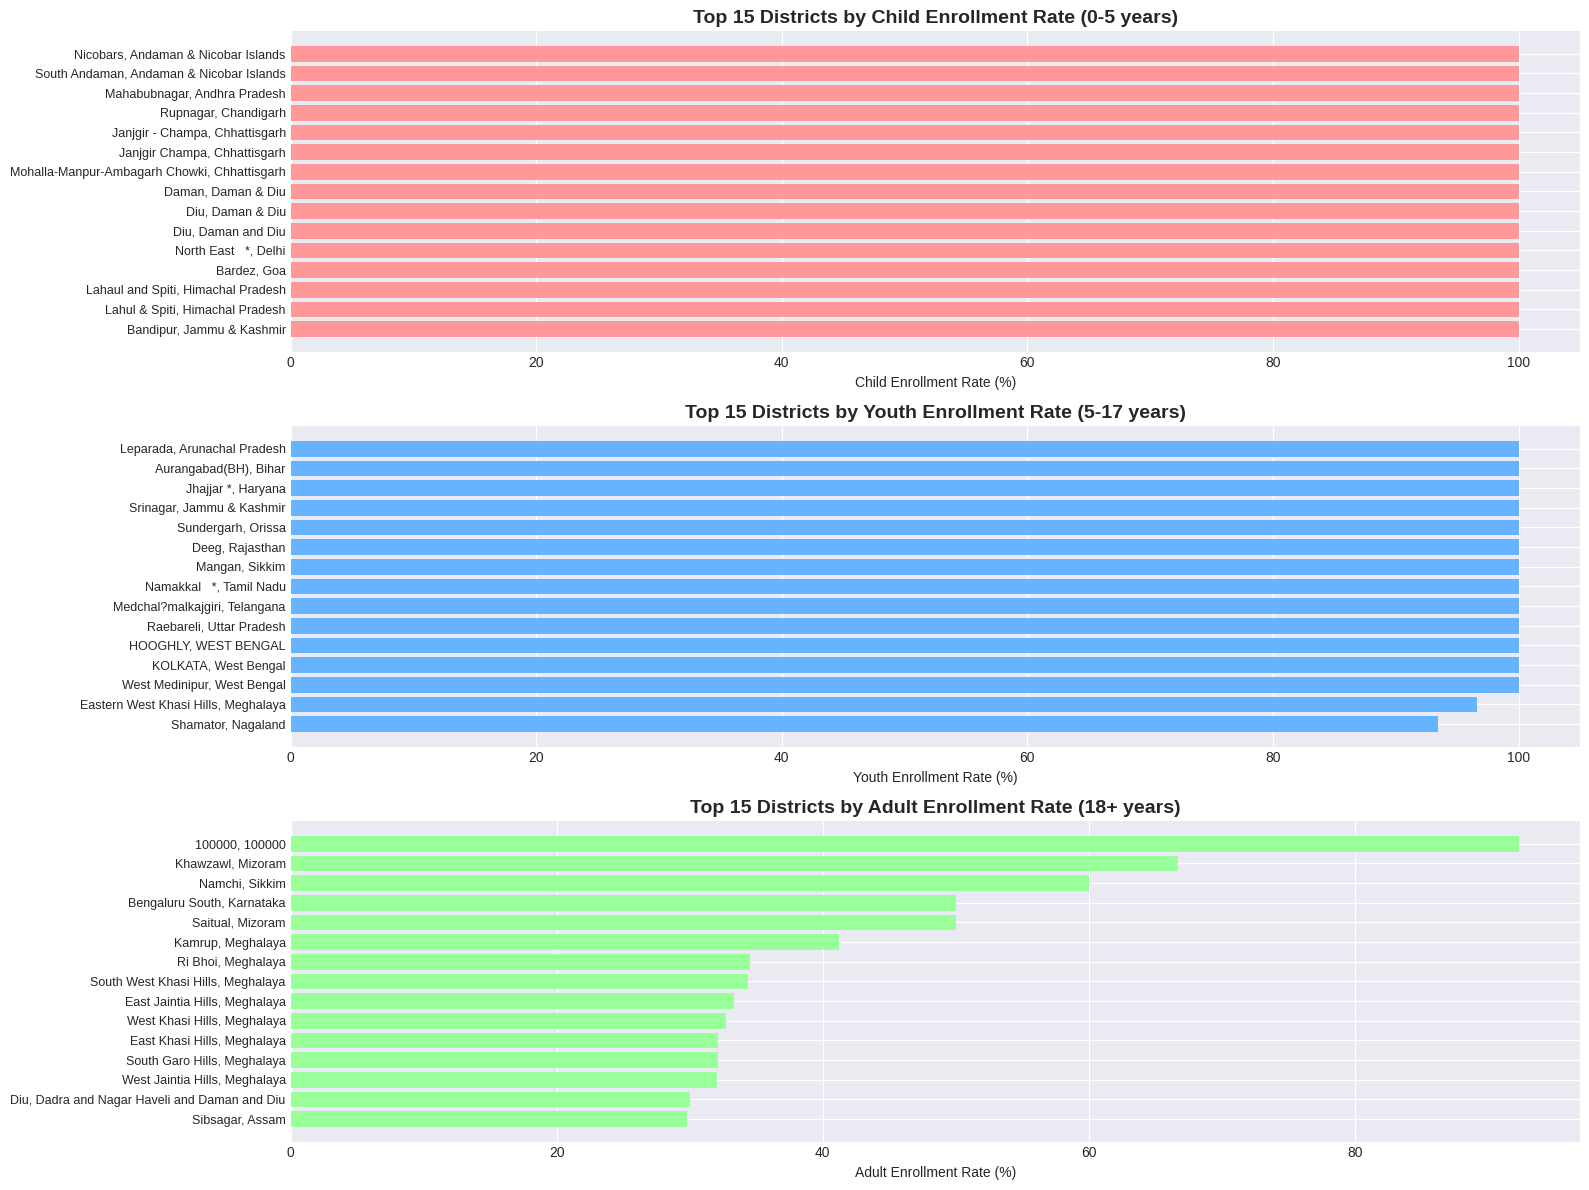


📊 Summary Statistics:

Total Enrollments:3,273,755
Average enrollments per pincode: 107.83
Median enrollments per pincode: 24.00

Age Group Breakdown:
  Children (0-5): 2,001,557 (61.1%)
  Youth (5-17): 1,149,853 (35.1%)
  Adults (18+): 122,345 (3.7%)

✅ PHASE 4 COMPLETE: Univariate Analysis Done!
✅ Generated 8 visualization files in 'figures' folder


In [5]:
# ========================================
# PHASE 4: Univariate Analysis
# ========================================

print("📊 Starting Univariate Analysis...")
print("=" * 60)

# Create figure directory
import os
os.makedirs('figures', exist_ok=True)

# Set visualization parameters
plt.rcParams['figure.figsize'] = (12, 6)
plt.rcParams['font.size'] = 10

# ==========================================
# 1. ENROLLMENT DISTRIBUTION ANALYSIS
# ==========================================

print("\n📈 1. Enrollment Distribution Analysis...")

# 1.1 Histogram: Distribution of enrollments per pincode
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Total enrollments distribution
axes[0, 0].hist(pincode_agg['total_enrollments'], bins=50, color='skyblue', edgecolor='black')
axes[0, 0].set_title('Distribution of Total Enrollments per Pincode', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Total Enrollments')
axes[0, 0].set_ylabel('Frequency')
axes[0, 0].axvline(pincode_agg['total_enrollments'].median(), color='red', linestyle='--', label=f'Median: {pincode_agg["total_enrollments"].median():.0f}')
axes[0, 0].legend()

# Log scale for better visualization
axes[0, 1].hist(np.log1p(pincode_agg['total_enrollments']), bins=50, color='lightcoral', edgecolor='black')
axes[0, 1].set_title('Distribution of Enrollments (Log Scale)', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Log(Total Enrollments + 1)')
axes[0, 1].set_ylabel('Frequency')

# Enrollment velocity distribution
axes[1, 0].hist(pincode_agg['enrollment_velocity'], bins=50, color='lightgreen', edgecolor='black')
axes[1, 0].set_title('Distribution of Enrollment Velocity', fontsize=14, fontweight='bold')
axes[1, 0].set_xlabel('Enrollments per Day')
axes[1, 0].set_ylabel('Frequency')

# Enrollment events distribution
axes[1, 1].hist(pincode_agg['enrollment_events'], bins=50, color='plum', edgecolor='black')
axes[1, 1].set_title('Distribution of Enrollment Events per Pincode', fontsize=14, fontweight='bold')
axes[1, 1].set_xlabel('Number of Events')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.savefig('figures/01_enrollment_distributions.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.2 Box plot: Enrollment distribution by state (top 15 states)
top_states = state_agg.head(15)['state'].tolist()
df_top_states = df_clean[df_clean['state'].isin(top_states)]

plt.figure(figsize=(16, 8))
df_top_states.boxplot(column='total_enrollments', by='state', figsize=(16, 8), rot=45)
plt.title('Enrollment Distribution by State (Top 15)', fontsize=16, fontweight='bold')
plt.suptitle('')  # Remove default title
plt.xlabel('State', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.yscale('log')
plt.tight_layout()
plt.savefig('figures/02_enrollment_boxplot_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.3 Top and Bottom performing pincodes
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# Top 20 pincodes
top_20_pincodes = pincode_agg.nlargest(20, 'total_enrollments')
axes[0].barh(range(20), top_20_pincodes['total_enrollments'], color='forestgreen')
axes[0].set_yticks(range(20))
axes[0].set_yticklabels([f"{row['pincode']}\n({row['district']}, {row['state']})"
                          for _, row in top_20_pincodes.iterrows()], fontsize=8)
axes[0].set_xlabel('Total Enrollments', fontsize=12)
axes[0].set_title('Top 20 Pincodes by Enrollment', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Bottom 20 pincodes (excluding zero)
bottom_20_pincodes = pincode_agg[pincode_agg['total_enrollments'] > 0].nsmallest(20, 'total_enrollments')
axes[1].barh(range(20), bottom_20_pincodes['total_enrollments'], color='firebrick')
axes[1].set_yticks(range(20))
axes[1].set_yticklabels([f"{row['pincode']}\n({row['district']}, {row['state']})"
                          for _, row in bottom_20_pincodes.iterrows()], fontsize=8)
axes[1].set_xlabel('Total Enrollments', fontsize=12)
axes[1].set_title('Bottom 20 Pincodes by Enrollment', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/03_top_bottom_pincodes.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.4 Time series: Monthly enrollment trends
monthly_trend = df_clean.groupby([df_clean['date'].dt.to_period('M')])['total_enrollments'].sum().reset_index()
monthly_trend['date'] = monthly_trend['date'].dt.to_timestamp()

plt.figure(figsize=(16, 6))
plt.plot(monthly_trend['date'], monthly_trend['total_enrollments'], marker='o', linewidth=2, color='navy')
plt.title('Monthly Enrollment Trends', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/04_monthly_enrollment_trends.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 2. GEOGRAPHIC COVERAGE ANALYSIS
# ==========================================

print("\n🗺️  2. Geographic Coverage Analysis...")

# 2.1 Pincode coverage metrics
zero_enrollment_pincodes = len(pincode_agg[pincode_agg['total_enrollments'] == 0])
low_enrollment_pincodes = len(pincode_agg[pincode_agg['total_enrollments'] < pincode_agg['total_enrollments'].quantile(0.1)])

print(f"\n📊 Coverage Metrics:")
print(f"   Zero enrollment pincodes: {zero_enrollment_pincodes}")
print(f"   Low enrollment pincodes (< 10th percentile): {low_enrollment_pincodes}")
print(f"   Total pincodes: {len(pincode_agg)}")

# 2.2 District coverage visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Pincodes per district
axes[0, 0].hist(district_agg['unique_pincodes'], bins=30, color='teal', edgecolor='black')
axes[0, 0].set_title('Distribution of Pincodes per District', fontsize=14, fontweight='bold')
axes[0, 0].set_xlabel('Number of Pincodes')
axes[0, 0].set_ylabel('Frequency')

# Enrollment density per district
axes[0, 1].hist(district_agg['enrollment_density'], bins=30, color='coral', edgecolor='black')
axes[0, 1].set_title('Distribution of Enrollment Density per District', fontsize=14, fontweight='bold')
axes[0, 1].set_xlabel('Enrollments per Pincode')
axes[0, 1].set_ylabel('Frequency')

# Top 15 districts by enrollment
top_15_districts = district_agg.nlargest(15, 'total_enrollments')
axes[1, 0].barh(range(15), top_15_districts['total_enrollments'], color='purple')
axes[1, 0].set_yticks(range(15))
axes[1, 0].set_yticklabels([f"{row['district']}, {row['state']}"
                             for _, row in top_15_districts.iterrows()], fontsize=9)
axes[1, 0].set_xlabel('Total Enrollments')
axes[1, 0].set_title('Top 15 Districts by Enrollment', fontsize=14, fontweight='bold')
axes[1, 0].invert_yaxis()

# Bottom 15 districts by enrollment
bottom_15_districts = district_agg.nsmallest(15, 'total_enrollments')
axes[1, 1].barh(range(15), bottom_15_districts['total_enrollments'], color='orangered')
axes[1, 1].set_yticks(range(15))
axes[1, 1].set_yticklabels([f"{row['district']}, {row['state']}"
                             for _, row in bottom_15_districts.iterrows()], fontsize=9)
axes[1, 1].set_xlabel('Total Enrollments')
axes[1, 1].set_title('Bottom 15 Districts by Enrollment', fontsize=14, fontweight='bold')
axes[1, 1].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/05_geographic_coverage.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. AGE GROUP ANALYSIS
# ==========================================

print("\n👥 3. Age Group Analysis...")

# 3.1 Overall age distribution (pie chart)
age_totals = {
    'Children (0-5)': df_clean['age_0_5'].sum(),
    'Youth (5-17)': df_clean['age_5_17'].sum(),
    'Adults (18+)': df_clean['age_18_greater'].sum()
}

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Pie chart
colors = ['#ff9999', '#66b3ff', '#99ff99']
axes[0].pie(age_totals.values(), labels=age_totals.keys(), autopct='%1.1f%%',
            startangle=90, colors=colors, textprops={'fontsize': 12})
axes[0].set_title('Overall Age Group Distribution', fontsize=14, fontweight='bold')

# Bar chart
axes[1].bar(age_totals.keys(), age_totals.values(), color=colors, edgecolor='black')
axes[1].set_title('Enrollment by Age Group', fontsize=14, fontweight='bold')
axes[1].set_ylabel('Total Enrollments')
axes[1].set_xlabel('Age Group')
for i, (k, v) in enumerate(age_totals.items()):
    axes[1].text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/06_age_group_distribution.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 Age distribution by state (top 10 states)
top_10_states = state_agg.head(10)

fig, ax = plt.subplots(figsize=(14, 8))
x = np.arange(len(top_10_states))
width = 0.25

bars1 = ax.bar(x - width, top_10_states['total_age_0_5'], width, label='Children (0-5)', color='#ff9999')
bars2 = ax.bar(x, top_10_states['total_age_5_17'], width, label='Youth (5-17)', color='#66b3ff')
bars3 = ax.bar(x + width, top_10_states['total_age_18_greater'], width, label='Adults (18+)', color='#99ff99')

ax.set_xlabel('State', fontsize=12)
ax.set_ylabel('Total Enrollments', fontsize=12)
ax.set_title('Age Distribution by State (Top 10)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(top_10_states['state'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/07_age_distribution_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.3 Age rate comparison across districts
fig, axes = plt.subplots(3, 1, figsize=(16, 12))

# Child enrollment rate
top_child = district_agg.nlargest(15, 'child_rate')
axes[0].barh(range(15), top_child['child_rate'], color='#ff9999')
axes[0].set_yticks(range(15))
axes[0].set_yticklabels([f"{row['district']}, {row['state']}" for _, row in top_child.iterrows()], fontsize=9)
axes[0].set_xlabel('Child Enrollment Rate (%)')
axes[0].set_title('Top 15 Districts by Child Enrollment Rate (0-5 years)', fontsize=14, fontweight='bold')
axes[0].invert_yaxis()

# Youth enrollment rate
top_youth = district_agg.nlargest(15, 'youth_rate')
axes[1].barh(range(15), top_youth['youth_rate'], color='#66b3ff')
axes[1].set_yticks(range(15))
axes[1].set_yticklabels([f"{row['district']}, {row['state']}" for _, row in top_youth.iterrows()], fontsize=9)
axes[1].set_xlabel('Youth Enrollment Rate (%)')
axes[1].set_title('Top 15 Districts by Youth Enrollment Rate (5-17 years)', fontsize=14, fontweight='bold')
axes[1].invert_yaxis()

# Adult enrollment rate
top_adult = district_agg.nlargest(15, 'adult_rate')
axes[2].barh(range(15), top_adult['adult_rate'], color='#99ff99')
axes[2].set_yticks(range(15))
axes[2].set_yticklabels([f"{row['district']}, {row['state']}" for _, row in top_adult.iterrows()], fontsize=9)
axes[2].set_xlabel('Adult Enrollment Rate (%)')
axes[2].set_title('Top 15 Districts by Adult Enrollment Rate (18+ years)', fontsize=14, fontweight='bold')
axes[2].invert_yaxis()

plt.tight_layout()
plt.savefig('figures/08_age_rate_comparison.png', dpi=300, bbox_inches='tight')
plt.show()

# Summary statistics
print("\n📊 Summary Statistics:")
print(f"\nTotal Enrollments:{df_clean['total_enrollments'].sum():,.0f}")
print(f"Average enrollments per pincode: {pincode_agg['total_enrollments'].mean():,.2f}")
print(f"Median enrollments per pincode: {pincode_agg['total_enrollments'].median():,.2f}")
print(f"\nAge Group Breakdown:")
print(f"  Children (0-5): {age_totals['Children (0-5)']:,.0f} ({age_totals['Children (0-5)']/sum(age_totals.values())*100:.1f}%)")
print(f"  Youth (5-17): {age_totals['Youth (5-17)']:,.0f} ({age_totals['Youth (5-17)']/sum(age_totals.values())*100:.1f}%)")
print(f"  Adults (18+): {age_totals['Adults (18+)']:,.0f} ({age_totals['Adults (18+)']/sum(age_totals.values())*100:.1f}%)")
print("\n" + "=" * 60)
print("✅ PHASE 4 COMPLETE: Univariate Analysis Done!")
print(f"✅ Generated 8 visualization files in 'figures' folder")
print("=" * 60)

📊 Starting Bivariate Analysis...

🗺️  1. Geography vs Enrollment Analysis...


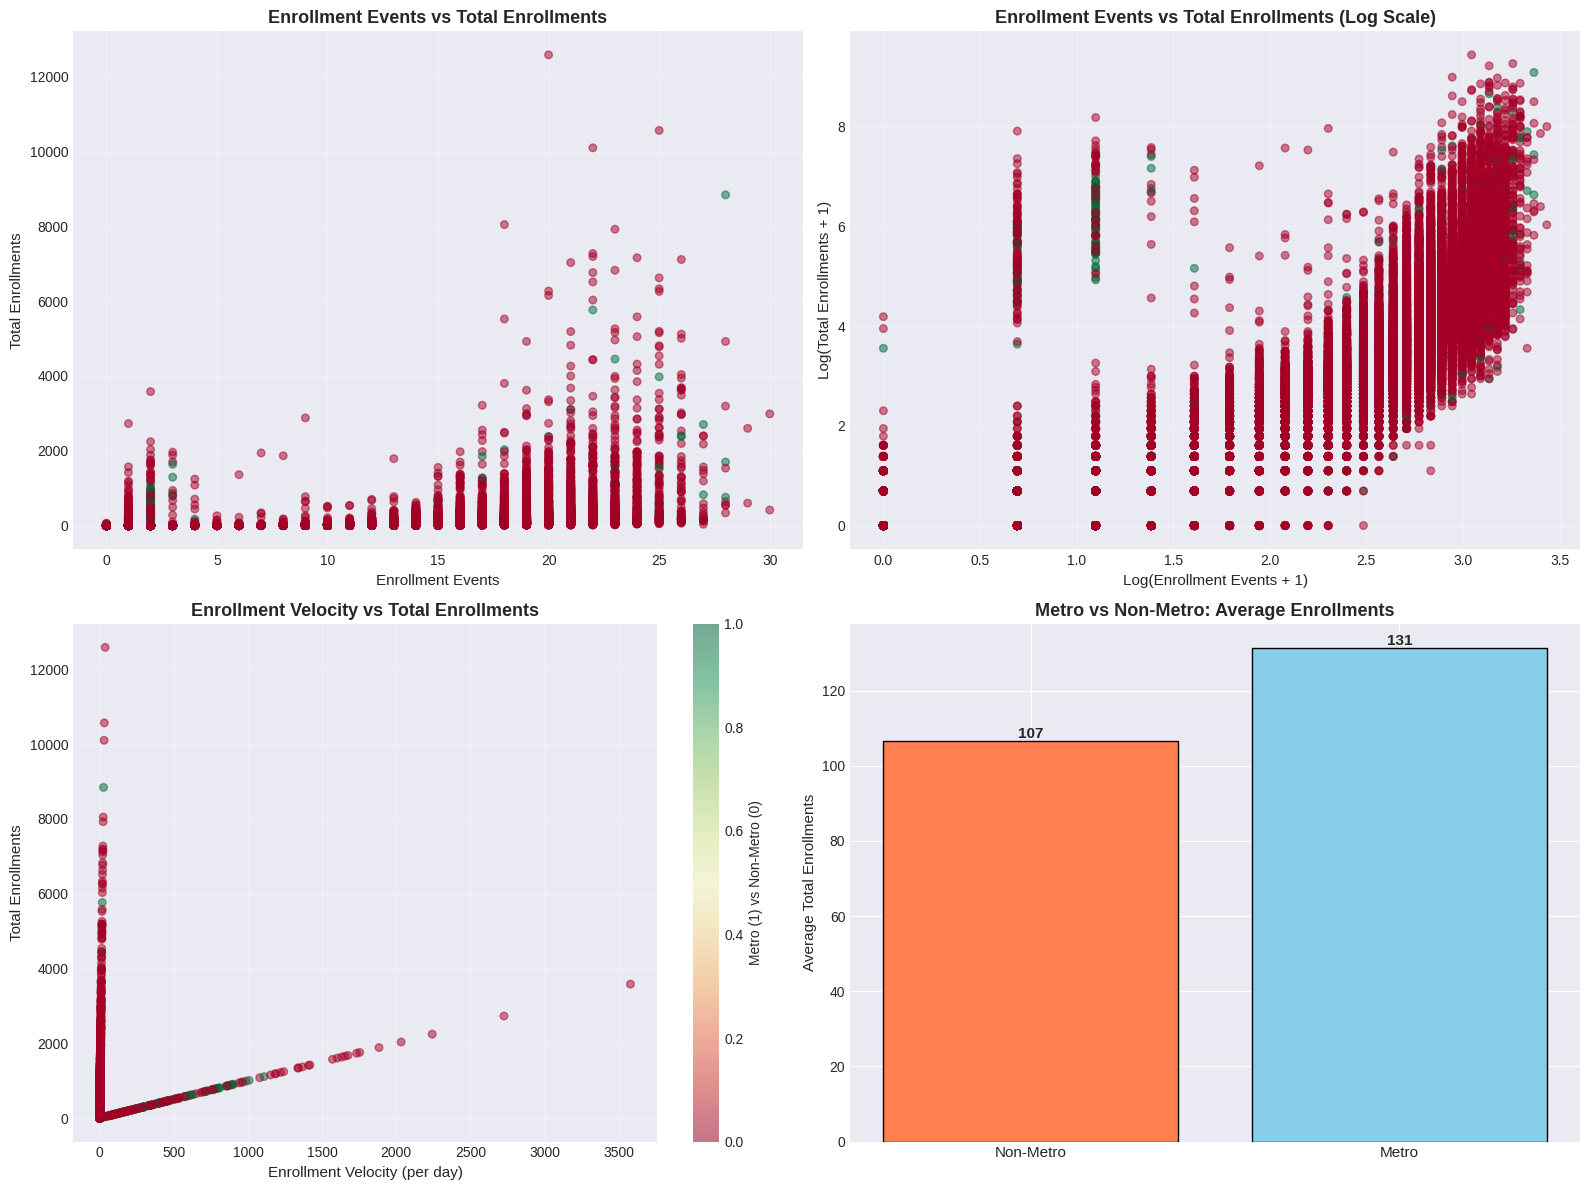


📊 Creating State × District Enrollment Heatmap...


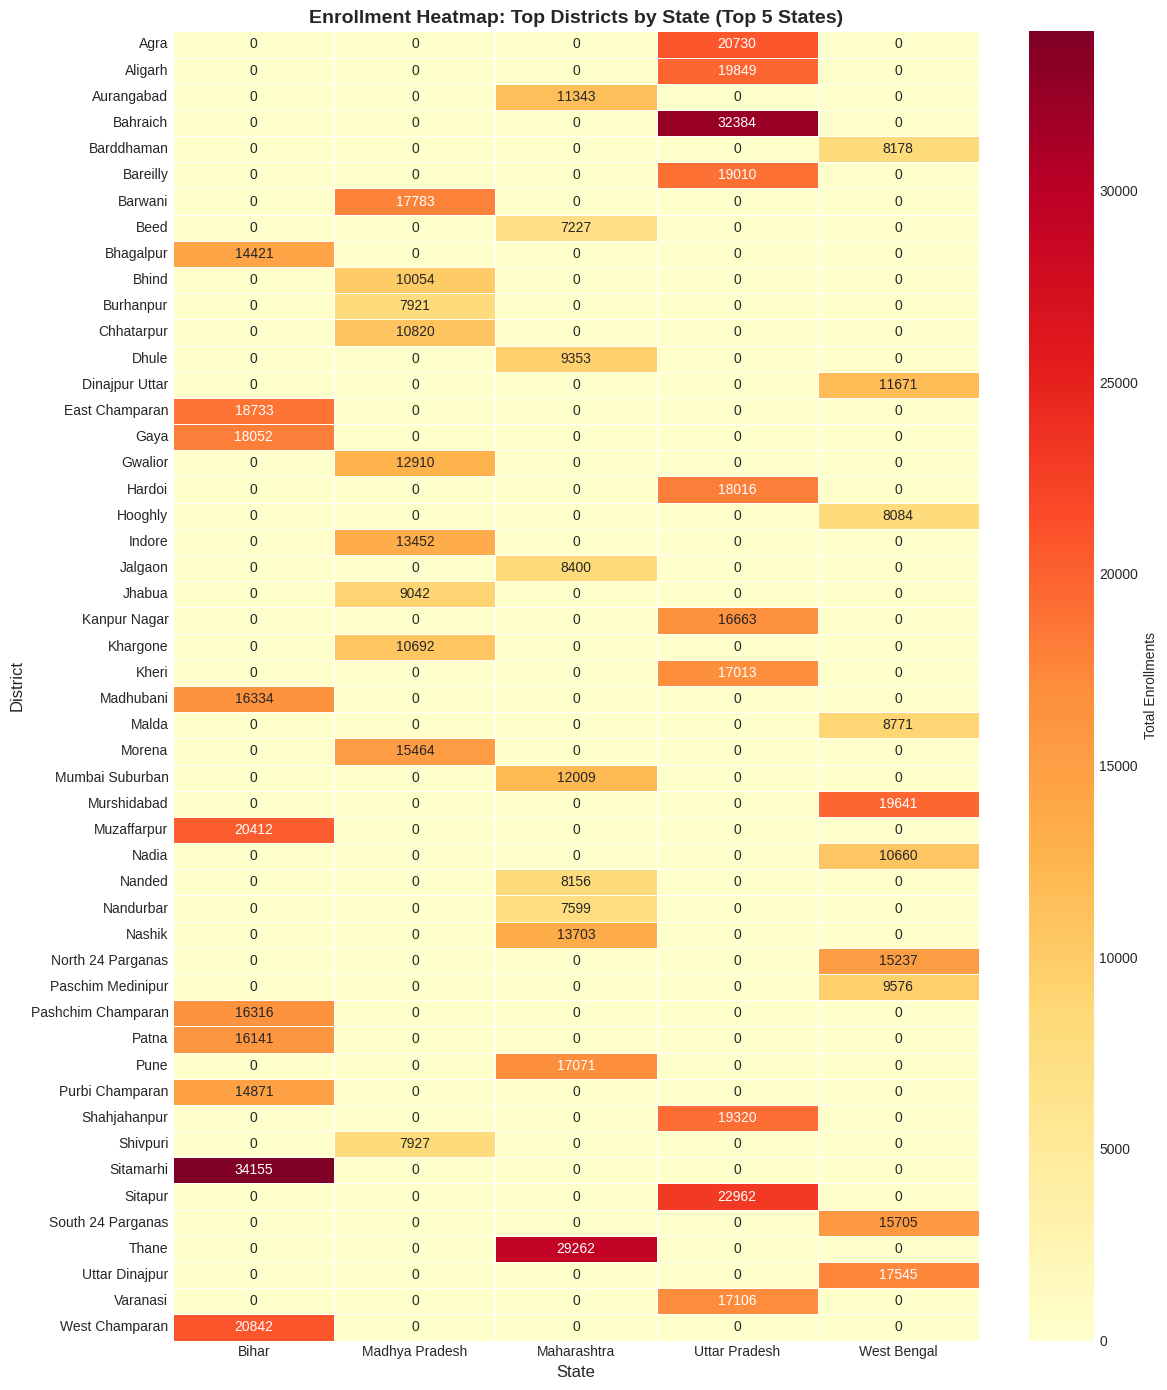


⏰ 2. Time vs Enrollment Analysis...


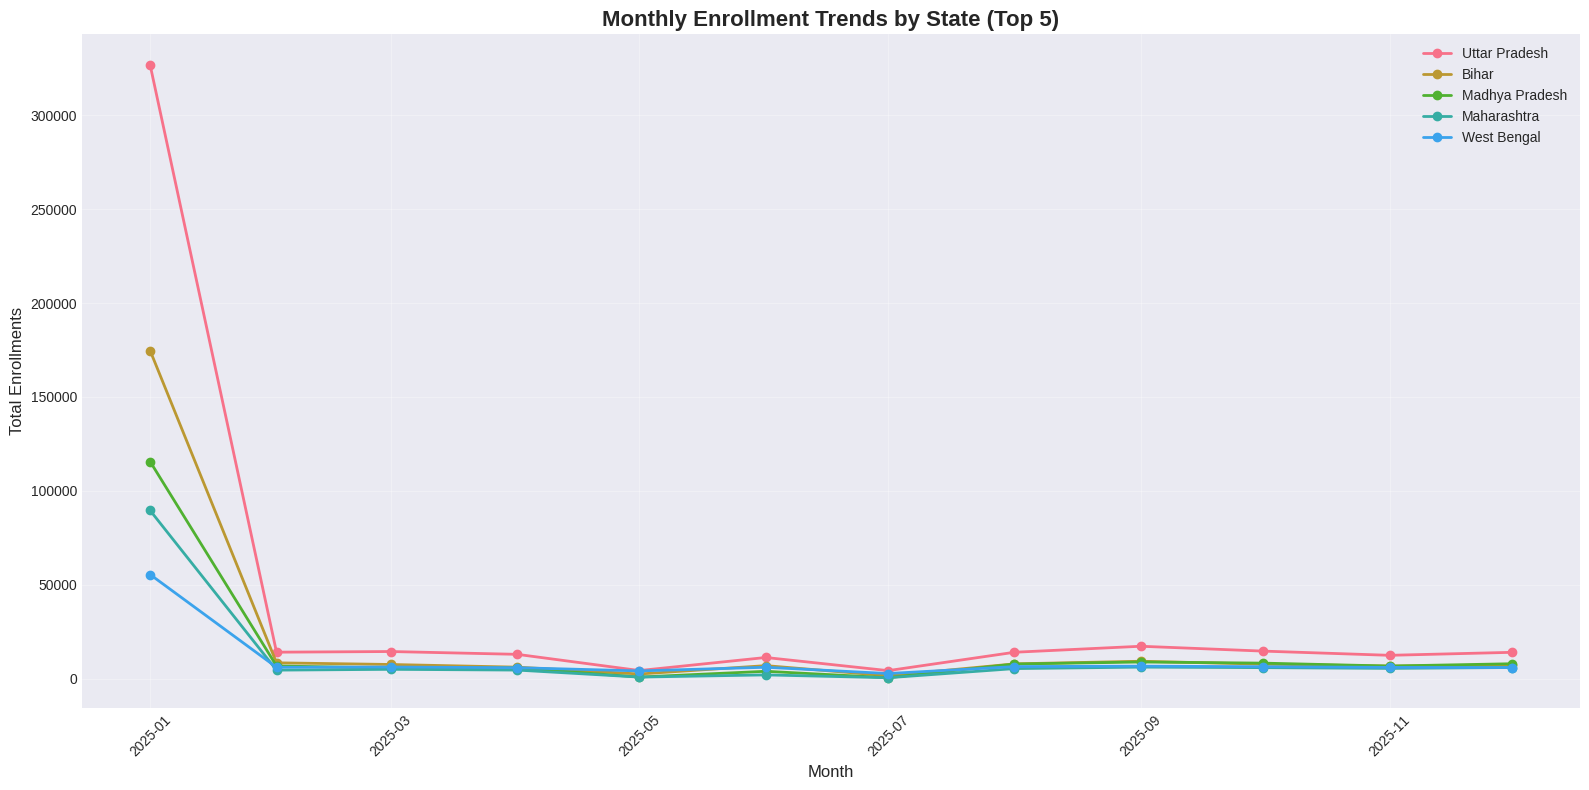

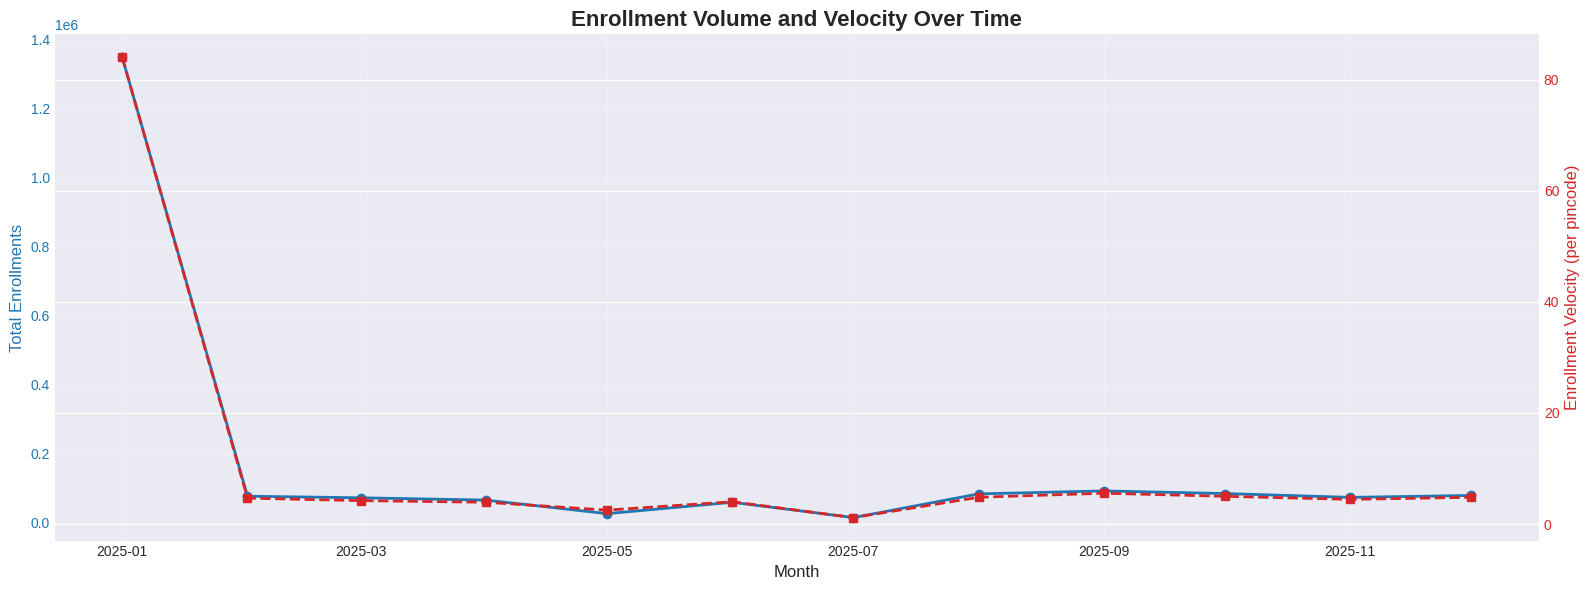

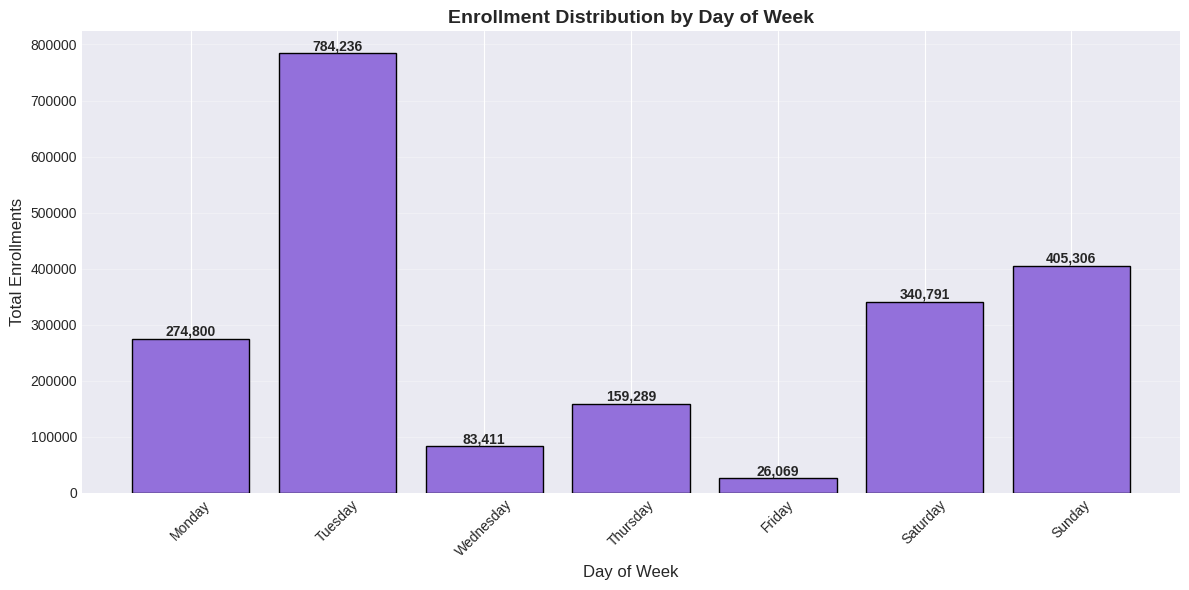


👥 3. Demographics vs Geography Analysis...


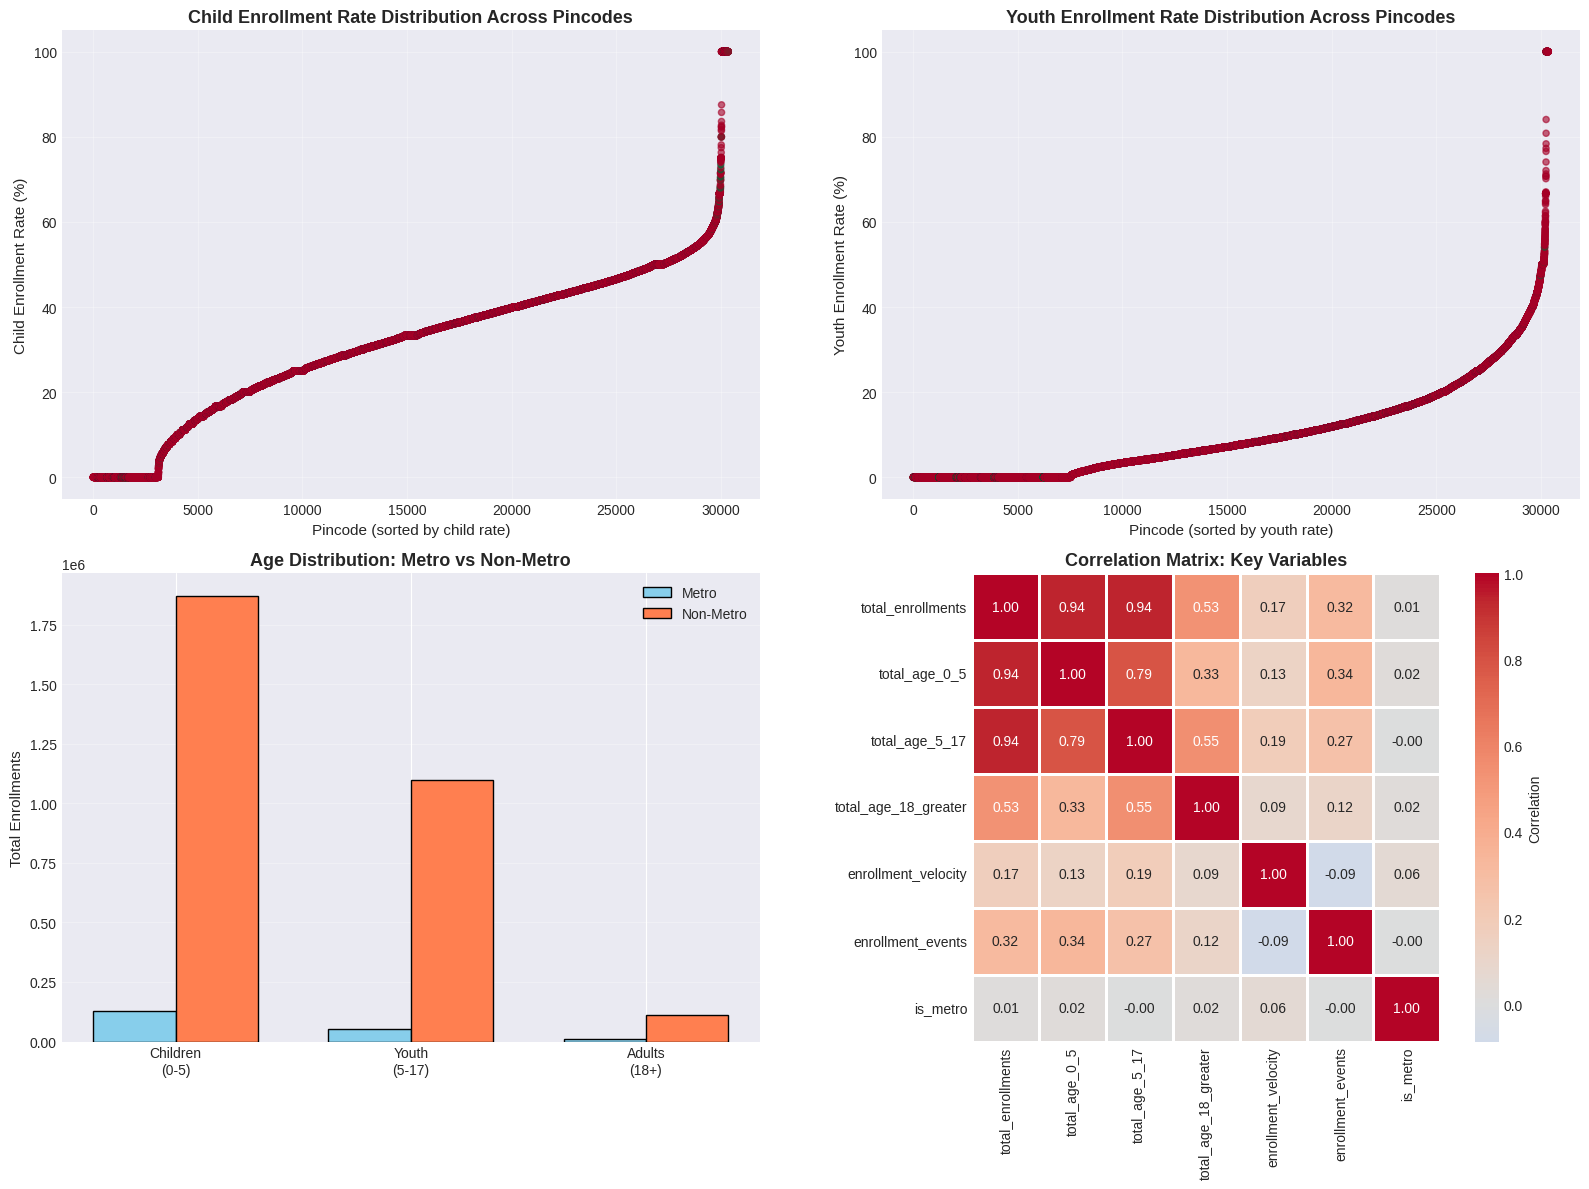

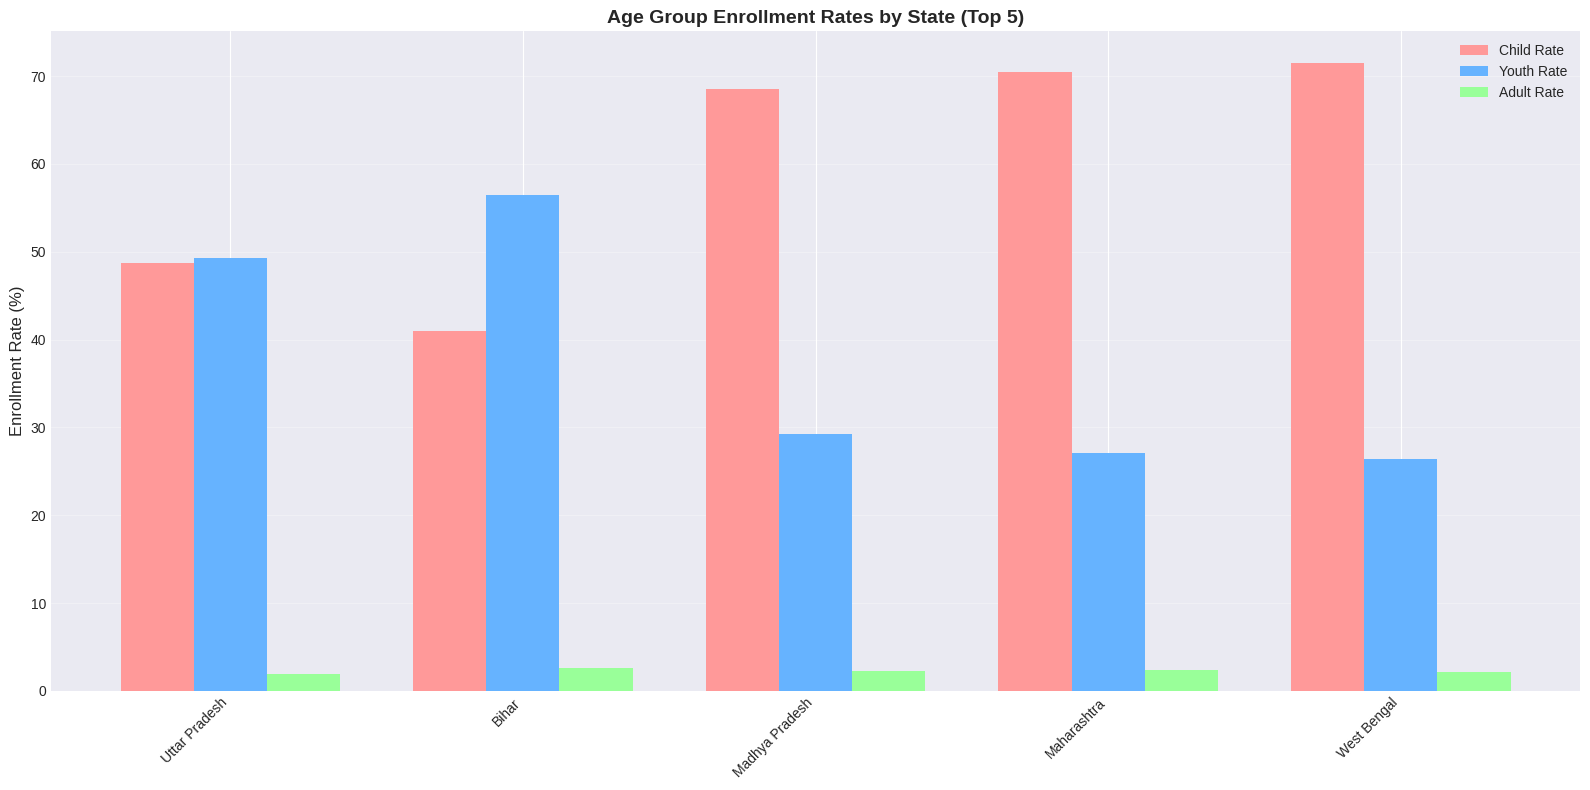


📊 Bivariate Analysis Key Insights:
   Metro pincodes average: 131 enrollments
   Non-metro pincodes average: 107 enrollments
   Correlation (events vs enrollments): 0.321
   Correlation (velocity vs enrollments): 0.166

✅ PHASE 5 COMPLETE: Bivariate Analysis Done!
✅ Generated 7 additional visualization files


In [7]:


## **PHASE 5: Bivariate Analysis**

# ========================================
# PHASE 5: Bivariate Analysis
# ========================================

print("📊 Starting Bivariate Analysis...")
print("=" * 60)

# ==========================================
# 1. GEOGRAPHY VS ENROLLMENT
# ==========================================

print("\n🗺️  1. Geography vs Enrollment Analysis...")

# 1.1 Scatter plot: Enrollment events vs total enrollments
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Enrollment events vs total enrollments
axes[0, 0].scatter(pincode_agg['enrollment_events'], pincode_agg['total_enrollments'],
                   alpha=0.5, c=pincode_agg['is_metro'], cmap='RdYlGn', s=30)
axes[0, 0].set_xlabel('Enrollment Events', fontsize=11)
axes[0, 0].set_ylabel('Total Enrollments', fontsize=11)
axes[0, 0].set_title('Enrollment Events vs Total Enrollments', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Log-log scale for better visualization
axes[0, 1].scatter(np.log1p(pincode_agg['enrollment_events']),
                   np.log1p(pincode_agg['total_enrollments']),
                   alpha=0.5, c=pincode_agg['is_metro'], cmap='RdYlGn', s=30)
axes[0, 1].set_xlabel('Log(Enrollment Events + 1)', fontsize=11)
axes[0, 1].set_ylabel('Log(Total Enrollments + 1)', fontsize=11)
axes[0, 1].set_title('Enrollment Events vs Total Enrollments (Log Scale)', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Enrollment velocity vs total enrollments
scatter = axes[1, 0].scatter(pincode_agg['enrollment_velocity'],
                             pincode_agg['total_enrollments'],
                             alpha=0.5, c=pincode_agg['is_metro'], cmap='RdYlGn', s=30)
axes[1, 0].set_xlabel('Enrollment Velocity (per day)', fontsize=11)
axes[1, 0].set_ylabel('Total Enrollments', fontsize=11)
axes[1, 0].set_title('Enrollment Velocity vs Total Enrollments', fontsize=13, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
plt.colorbar(scatter, ax=axes[1, 0], label='Metro (1) vs Non-Metro (0)')

# Urban vs Rural comparison
urban_rural_data = pincode_agg.groupby('is_metro')[['total_enrollments', 'enrollment_velocity']].mean()
x_pos = np.arange(len(urban_rural_data))
axes[1, 1].bar(x_pos, urban_rural_data['total_enrollments'], color=['coral', 'skyblue'], edgecolor='black')
axes[1, 1].set_xticks(x_pos)
axes[1, 1].set_xticklabels(['Non-Metro', 'Metro'], fontsize=11)
axes[1, 1].set_ylabel('Average Total Enrollments', fontsize=11)
axes[1, 1].set_title('Metro vs Non-Metro: Average Enrollments', fontsize=13, fontweight='bold')
for i, v in enumerate(urban_rural_data['total_enrollments']):
    axes[1, 1].text(i, v, f'{v:.0f}', ha='center', va='bottom', fontsize=11, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/09_geography_vs_enrollment.png', dpi=300, bbox_inches='tight')
plt.show()

# 1.2 State × District heatmap (top 5 states, top districts)
print("\n📊 Creating State × District Enrollment Heatmap...")

# Select top 5 states
top_5_states = state_agg.head(5)['state'].tolist()
district_subset = district_agg[district_agg['state'].isin(top_5_states)]

# Get top 10 districts per state
top_districts_per_state = []
for state in top_5_states:
    state_districts = district_subset[district_subset['state'] == state].nlargest(10, 'total_enrollments')
    top_districts_per_state.append(state_districts)

district_pivot = pd.concat(top_districts_per_state)

# Create pivot table
pivot_data = district_pivot.pivot_table(
    values='total_enrollments',
    index='district',
    columns='state',
    fill_value=0
)

plt.figure(figsize=(12, 14))
sns.heatmap(pivot_data, annot=True, fmt='.0f', cmap='YlOrRd', cbar_kws={'label': 'Total Enrollments'}, linewidths=0.5)
plt.title('Enrollment Heatmap: Top Districts by State (Top 5 States)', fontsize=14, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('District', fontsize=12)
plt.tight_layout()
plt.savefig('figures/10_state_district_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 2. TIME VS ENROLLMENT
# ==========================================

print("\n⏰ 2. Time vs Enrollment Analysis...")

# 2.1 Monthly enrollment trends by state (top 5)
monthly_state_trend = df_clean[df_clean['state'].isin(top_5_states)].groupby(
    [df_clean['date'].dt.to_period('M'), 'state']
)['total_enrollments'].sum().reset_index()
monthly_state_trend['date'] = monthly_state_trend['date'].dt.to_timestamp()

plt.figure(figsize=(16, 8))
for state in top_5_states:
    state_data = monthly_state_trend[monthly_state_trend['state'] == state]
    plt.plot(state_data['date'], state_data['total_enrollments'],
             marker='o', linewidth=2, label=state)

plt.title('Monthly Enrollment Trends by State (Top 5)', fontsize=16, fontweight='bold')
plt.xlabel('Month', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.legend(loc='best', fontsize=10)
plt.grid(True, alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig('figures/11_monthly_trends_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.2 Enrollment velocity over time
# Create monthly aggregation with velocity
monthly_velocity = df_clean.groupby(df_clean['date'].dt.to_period('M')).agg({
    'total_enrollments': 'sum',
    'pincode': 'nunique'
}).reset_index()
monthly_velocity['date'] = monthly_velocity['date'].dt.to_timestamp()
monthly_velocity['velocity'] = monthly_velocity['total_enrollments'] / monthly_velocity['pincode']

fig, ax1 = plt.subplots(figsize=(16, 6))

color = 'tab:blue'
ax1.set_xlabel('Month', fontsize=12)
ax1.set_ylabel('Total Enrollments', color=color, fontsize=12)
ax1.plot(monthly_velocity['date'], monthly_velocity['total_enrollments'],
         color=color, marker='o', linewidth=2, label='Total Enrollments')
ax1.tick_params(axis='y', labelcolor=color)
ax1.grid(True, alpha=0.3)

ax2 = ax1.twinx()
color = 'tab:red'
ax2.set_ylabel('Enrollment Velocity (per pincode)', color=color, fontsize=12)
ax2.plot(monthly_velocity['date'], monthly_velocity['velocity'],
         color=color, marker='s', linewidth=2, label='Velocity', linestyle='--')
ax2.tick_params(axis='y', labelcolor=color)

plt.title('Enrollment Volume and Velocity Over Time', fontsize=16, fontweight='bold')
plt.xticks(rotation=45)
fig.tight_layout()
plt.savefig('figures/12_enrollment_velocity_over_time.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.3 Day of week analysis
day_of_week_enrollment = df_clean.groupby('enrollment_day_of_week')['total_enrollments'].sum()
days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']

plt.figure(figsize=(12, 6))
plt.bar(range(7), day_of_week_enrollment, color='mediumpurple', edgecolor='black')
plt.xticks(range(7), days, rotation=45)
plt.xlabel('Day of Week', fontsize=12)
plt.ylabel('Total Enrollments', fontsize=12)
plt.title('Enrollment Distribution by Day of Week', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3, axis='y')
for i, v in enumerate(day_of_week_enrollment):
    plt.text(i, v, f'{v:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')
plt.tight_layout()
plt.savefig('figures/13_day_of_week_analysis.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. DEMOGRAPHICS VS GEOGRAPHY
# ==========================================

print("\n👥 3. Demographics vs Geography Analysis...")

# 3.1 Child enrollment rate vs pincode
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Child enrollment rate distribution
axes[0, 0].scatter(range(len(pincode_agg)),
                   pincode_agg.sort_values('avg_child_rate')['avg_child_rate'],
                   c=pincode_agg.sort_values('avg_child_rate')['is_metro'],
                   cmap='RdYlGn', alpha=0.6, s=20)
axes[0, 0].set_xlabel('Pincode (sorted by child rate)', fontsize=11)
axes[0, 0].set_ylabel('Child Enrollment Rate (%)', fontsize=11)
axes[0, 0].set_title('Child Enrollment Rate Distribution Across Pincodes', fontsize=13, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)

# Youth enrollment rate distribution
axes[0, 1].scatter(range(len(pincode_agg)),
                   pincode_agg.sort_values('avg_youth_rate')['avg_youth_rate'],
                   c=pincode_agg.sort_values('avg_youth_rate')['is_metro'],
                   cmap='RdYlGn', alpha=0.6, s=20)
axes[0, 1].set_xlabel('Pincode (sorted by youth rate)', fontsize=11)
axes[0, 1].set_ylabel('Youth Enrollment Rate (%)', fontsize=11)
axes[0, 1].set_title('Youth Enrollment Rate Distribution Across Pincodes', fontsize=13, fontweight='bold')
axes[0, 1].grid(True, alpha=0.3)

# Metro vs Non-Metro age distribution
metro_age = pincode_agg[pincode_agg['is_metro'] == 1][['total_age_0_5', 'total_age_5_17', 'total_age_18_greater']].sum()
non_metro_age = pincode_agg[pincode_agg['is_metro'] == 0][['total_age_0_5', 'total_age_5_17', 'total_age_18_greater']].sum()

x = np.arange(3)
width = 0.35
age_groups = ['Children\n(0-5)', 'Youth\n(5-17)', 'Adults\n(18+)']

axes[1, 0].bar(x - width/2, metro_age, width, label='Metro', color='skyblue', edgecolor='black')
axes[1, 0].bar(x + width/2, non_metro_age, width, label='Non-Metro', color='coral', edgecolor='black')
axes[1, 0].set_ylabel('Total Enrollments', fontsize=11)
axes[1, 0].set_title('Age Distribution: Metro vs Non-Metro', fontsize=13, fontweight='bold')
axes[1, 0].set_xticks(x)
axes[1, 0].set_xticklabels(age_groups)
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3, axis='y')

# Correlation heatmap
correlation_data = pincode_agg[[
    'total_enrollments', 'total_age_0_5', 'total_age_5_17', 'total_age_18_greater',
    'enrollment_velocity', 'enrollment_events', 'is_metro'
]].corr()

sns.heatmap(correlation_data, annot=True, fmt='.2f', cmap='coolwarm',
            center=0, square=True, linewidths=1, ax=axes[1, 1],
            cbar_kws={'label': 'Correlation'})
axes[1, 1].set_title('Correlation Matrix: Key Variables', fontsize=13, fontweight='bold')

plt.tight_layout()
plt.savefig('figures/14_demographics_vs_geography.png', dpi=300, bbox_inches='tight')
plt.show()

# 3.2 State-wise age group rates comparison
fig, ax = plt.subplots(figsize=(16, 8))

x = np.arange(len(top_5_states))
width = 0.25

state_subset = state_agg[state_agg['state'].isin(top_5_states)]

bars1 = ax.bar(x - width, state_subset['child_rate'], width, label='Child Rate', color='#ff9999')
bars2 = ax.bar(x, state_subset['youth_rate'], width, label='Youth Rate', color='#66b3ff')
bars3 = ax.bar(x + width, state_subset['adult_rate'], width, label='Adult Rate', color='#99ff99')

ax.set_ylabel('Enrollment Rate (%)', fontsize=12)
ax.set_title('Age Group Enrollment Rates by State (Top 5)', fontsize=14, fontweight='bold')
ax.set_xticks(x)
ax.set_xticklabels(state_subset['state'], rotation=45, ha='right')
ax.legend()
ax.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('figures/15_age_rates_by_state.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Bivariate Analysis Key Insights:")
print(f"   Metro pincodes average: {pincode_agg[pincode_agg['is_metro']==1]['total_enrollments'].mean():.0f} enrollments")
print(f"   Non-metro pincodes average: {pincode_agg[pincode_agg['is_metro']==0]['total_enrollments'].mean():.0f} enrollments")
print(f"   Correlation (events vs enrollments): {pincode_agg['enrollment_events'].corr(pincode_agg['total_enrollments']):.3f}")
print(f"   Correlation (velocity vs enrollments): {pincode_agg['enrollment_velocity'].corr(pincode_agg['total_enrollments']):.3f}")

print("\n" + "=" * 60)
print("✅ PHASE 5 COMPLETE: Bivariate Analysis Done!")
print(f"✅ Generated 7 additional visualization files")
print("=" * 60)

📊 Starting Trivariate Analysis...

🌐 1. Creating Interactive Visualizations...
✅ Created: 16_3d_scatter_plot.html
✅ Created: 17_animated_bubble_chart.html
✅ Created: 18_sunburst_hierarchy.html

🔥 2. Creating Multi-Dimensional Heatmaps...


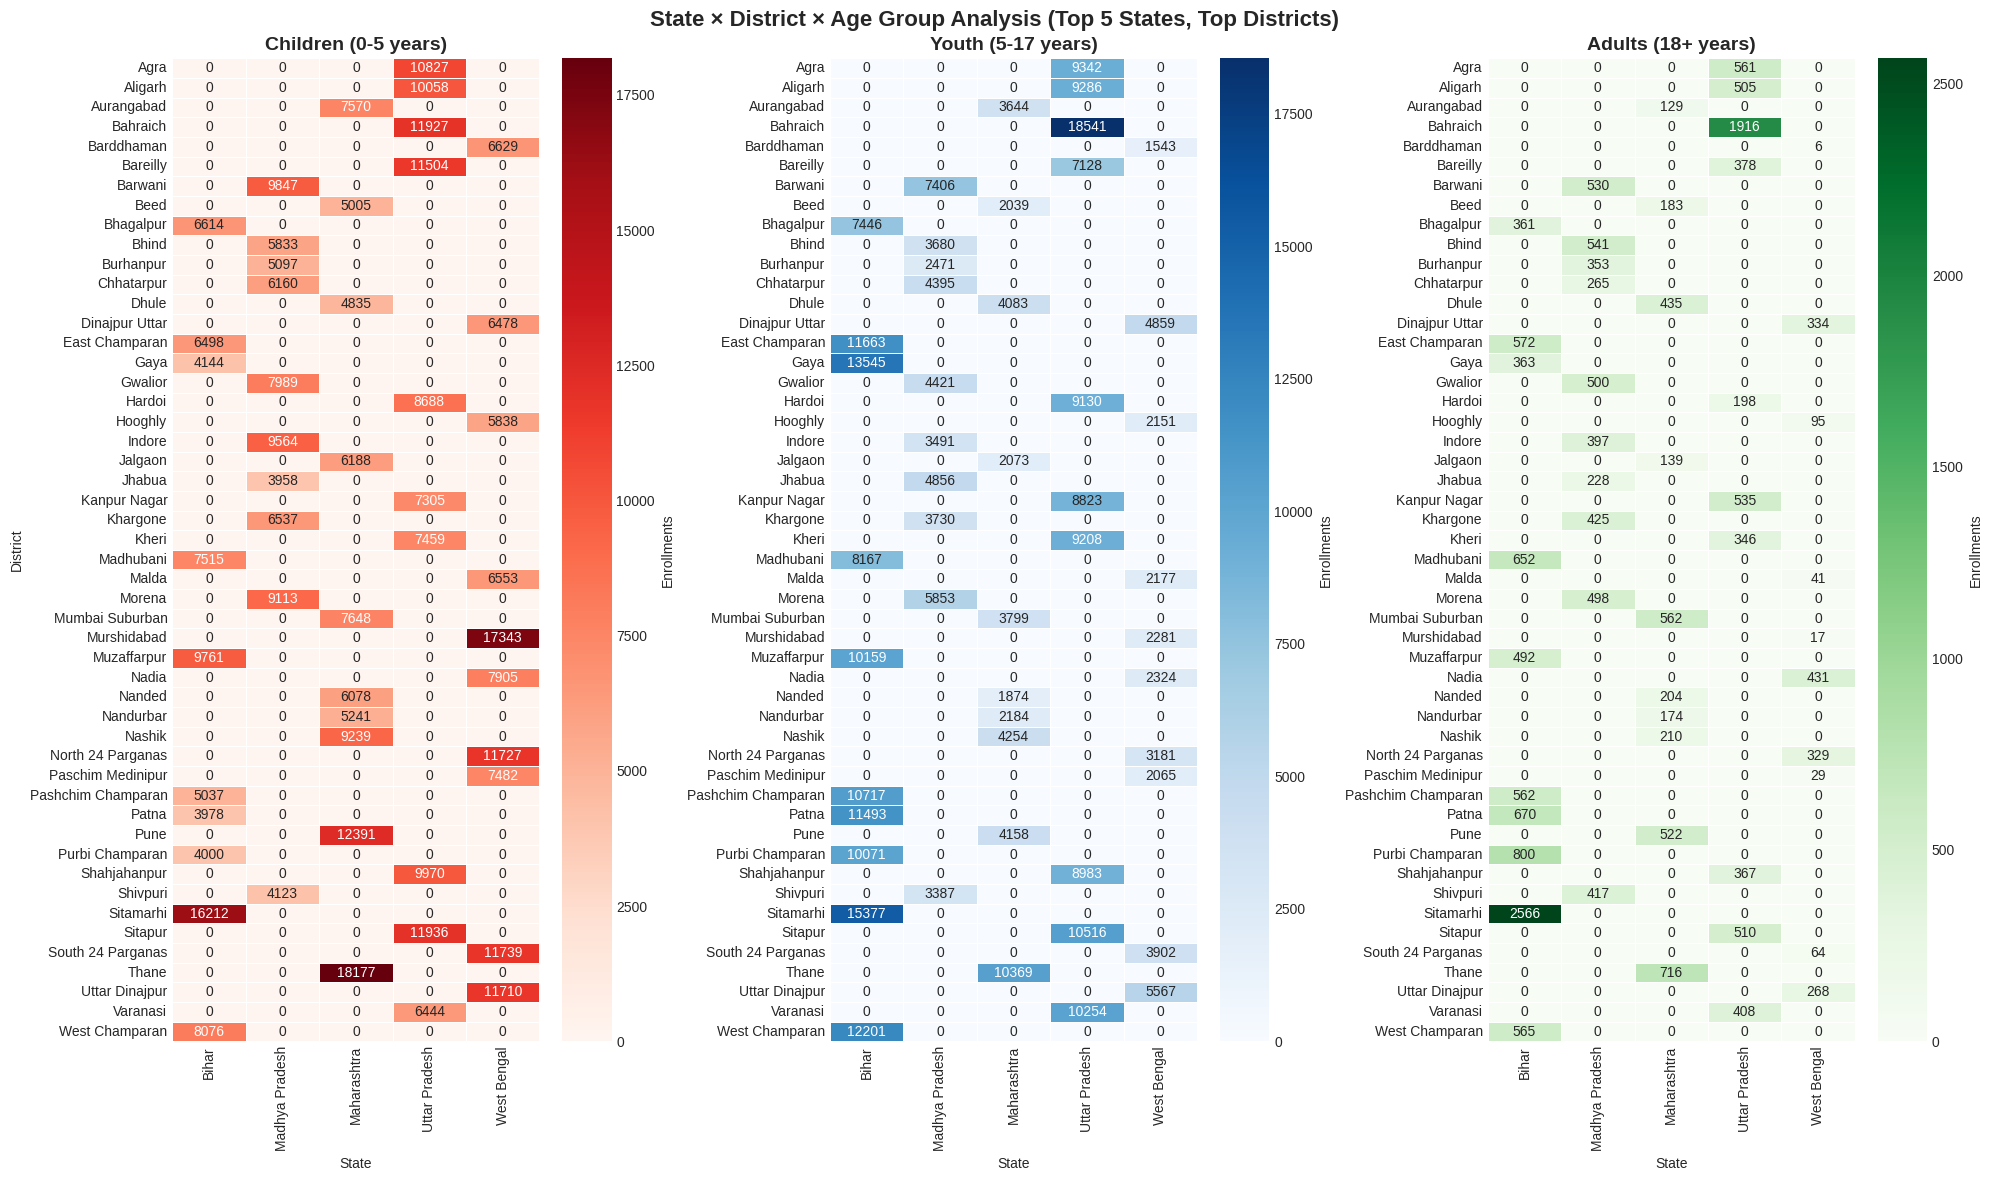

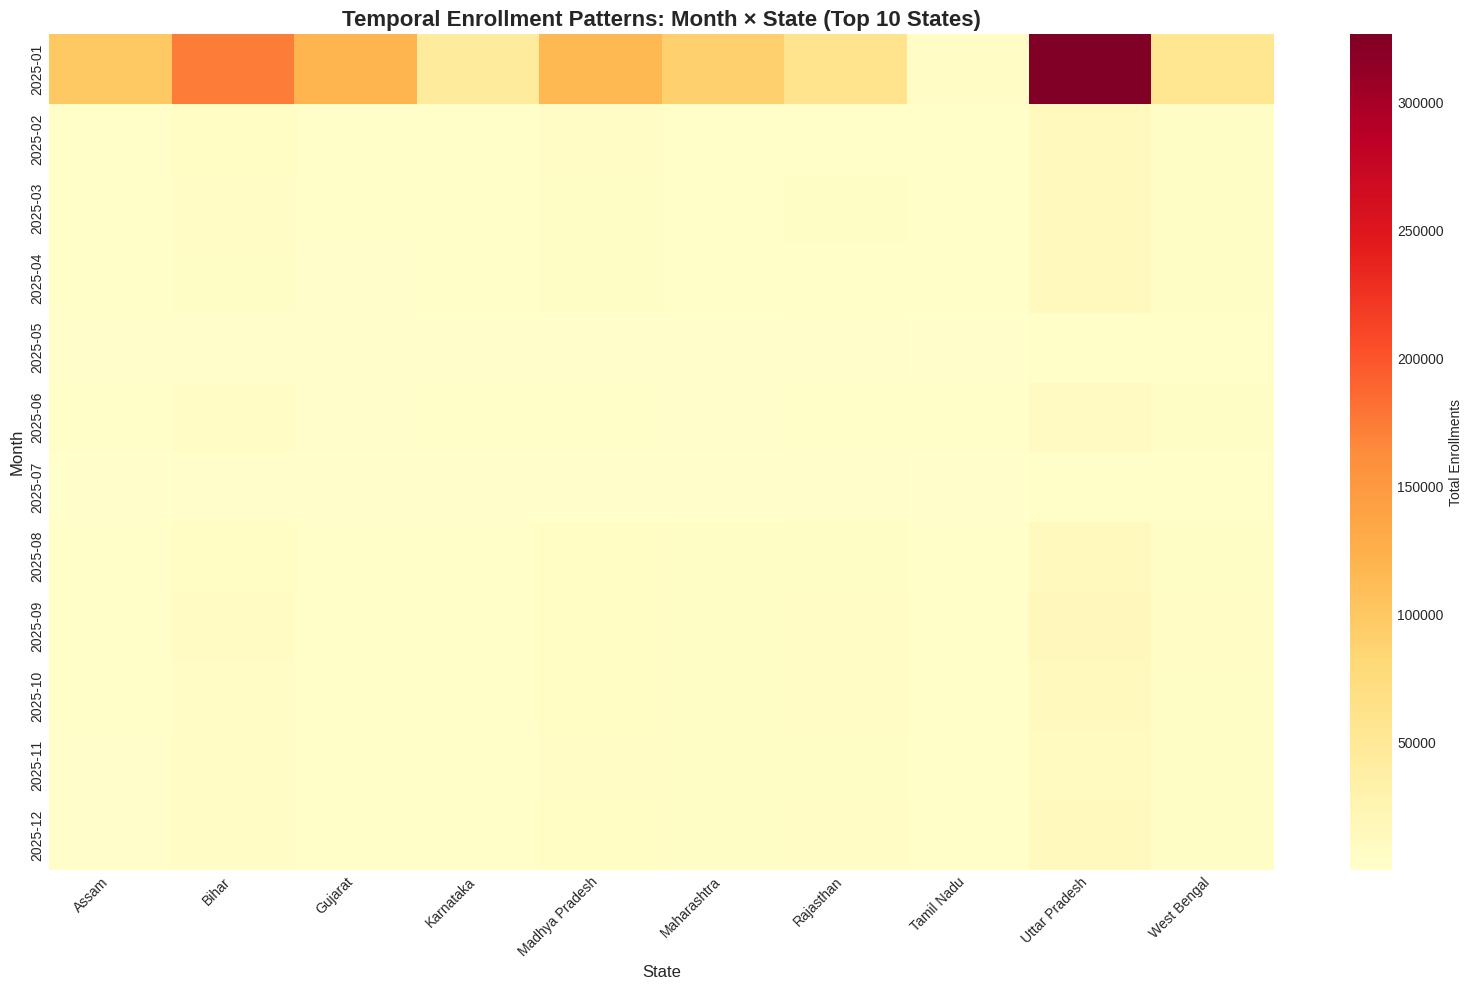


📊 3. Complex Multi-Variable Analysis...


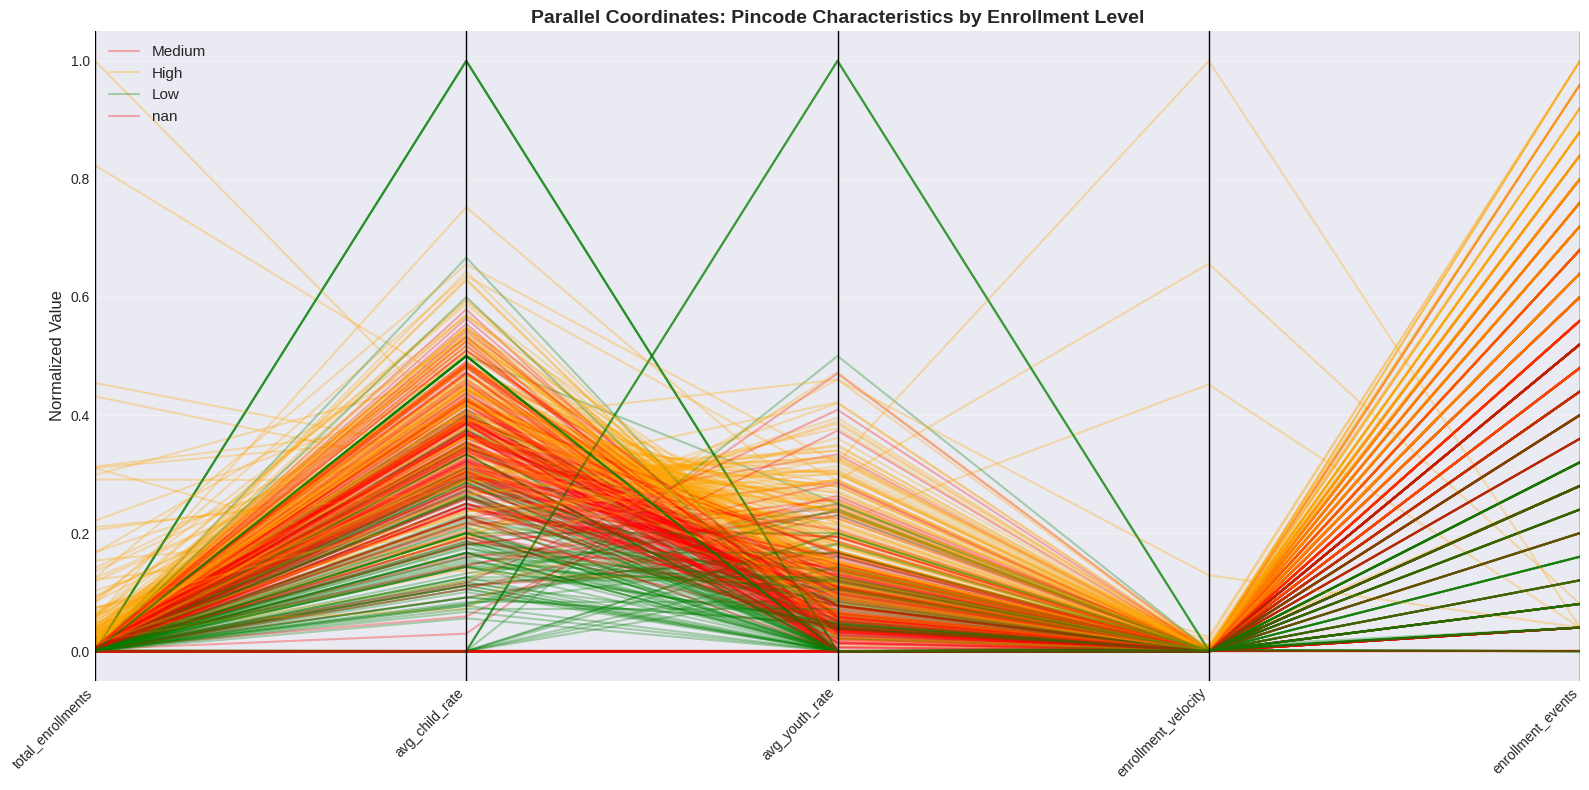


📊 Trivariate Analysis Summary:
   Created 6 advanced visualizations
   Interactive HTML files: 3
   Static complex plots: 3

✅ PHASE 6 COMPLETE: Trivariate Analysis Done!


In [8]:
## **PHASE 6: Trivariate Analysis & Advanced Visualizations**

# ========================================
# PHASE 6: Trivariate Analysis
# ========================================

print("📊 Starting Trivariate Analysis...")
print("=" * 60)

# ==========================================
# 1. INTERACTIVE PLOTLY VISUALIZATIONS
# ==========================================

print("\n🌐 1. Creating Interactive Visualizations...")

# 1.1 3D Scatter Plot: Child Rate × Total Enrollments × Enrollment Velocity
fig = go.Figure(data=[go.Scatter3d(
    x=pincode_agg['avg_child_rate'],
    y=np.log1p(pincode_agg['total_enrollments']),
    z=pincode_agg['enrollment_velocity'],
    mode='markers',
    marker=dict(
        size=4,
        color=pincode_agg['is_metro'],
        colorscale='Viridis',
        showscale=True,
        colorbar=dict(title="Metro Status"),
        opacity=0.7
    ),
    text=[f"Pincode: {p}<br>State: {s}<br>District: {d}"
          for p, s, d in zip(pincode_agg['pincode'], pincode_agg['state'], pincode_agg['district'])],
    hovertemplate='<b>%{text}</b><br>Child Rate: %{x:.1f}%<br>Log(Enrollments): %{y:.2f}<br>Velocity: %{z:.2f}<extra></extra>'
)])

fig.update_layout(
    title='3D Analysis: Child Rate × Enrollments × Velocity',
    scene=dict(
        xaxis_title='Child Enrollment Rate (%)',
        yaxis_title='Log(Total Enrollments + 1)',
        zaxis_title='Enrollment Velocity'
    ),
    width=900,
    height=700
)

fig.write_html('figures/16_3d_scatter_plot.html')
print("✅ Created: 16_3d_scatter_plot.html")

# 1.2 Animated bubble chart: State enrollments over time
# Prepare monthly state data
monthly_state_full = df_clean.groupby([
    df_clean['date'].dt.to_period('M'), 'state'
]).agg({
    'total_enrollments': 'sum',
    'age_0_5': 'sum',
    'age_5_17': 'sum',
    'age_18_greater': 'sum',
    'pincode': 'nunique'
}).reset_index()

monthly_state_full['date'] = monthly_state_full['date'].dt.to_timestamp()
monthly_state_full['date_str'] = monthly_state_full['date'].dt.strftime('%Y-%m')

# Get top 10 states for clearer visualization
top_10_states_list = state_agg.head(10)['state'].tolist()
monthly_state_top10 = monthly_state_full[monthly_state_full['state'].isin(top_10_states_list)]

fig = px.scatter(monthly_state_top10,
                 x='age_0_5',
                 y='age_18_greater',
                 animation_frame='date_str',
                 animation_group='state',
                 size='total_enrollments',
                 color='state',
                 hover_name='state',
                 size_max=60,
                 range_x=[0, monthly_state_top10['age_0_5'].max()*1.1],
                 range_y=[0, monthly_state_top10['age_18_greater'].max()*1.1],
                 labels={'age_0_5': 'Children Enrollments (0-5)',
                        'age_18_greater': 'Adult Enrollments (18+)',
                        'total_enrollments': 'Total Enrollments'},
                 title='Enrollment Dynamics Over Time: Children vs Adults (Top 10 States)')

fig.update_layout(width=1000, height=700)
fig.write_html('figures/17_animated_bubble_chart.html')
print("✅ Created: 17_animated_bubble_chart.html")

# 1.3 Sunburst chart: Hierarchical view (State → District → Age Distribution)
# Prepare data for sunburst
sunburst_data = []

for _, state_row in state_agg.head(5).iterrows():
    state_name = state_row['state']
    state_total = state_row['total_enrollments']

    # Get districts for this state
    state_districts = district_agg[district_agg['state'] == state_name].head(5)

    for _, dist_row in state_districts.iterrows():
        district_name = dist_row['district']

        # Add age group entries
        sunburst_data.append({
            'labels': state_name,
            'parents': '',
            'values': state_total
        })

        sunburst_data.append({
            'labels': f"{district_name}",
            'parents': state_name,
            'values': dist_row['total_enrollments']
        })

        # Age groups
        sunburst_data.append({
            'labels': f"Children (0-5)",
            'parents': f"{district_name}",
            'values': dist_row['total_age_0_5']
        })

        sunburst_data.append({
            'labels': f"Youth (5-17)",
            'parents': f"{district_name}",
            'values': dist_row['total_age_5_17']
        })

        sunburst_data.append({
            'labels': f"Adults (18+)",
            'parents': f"{district_name}",
            'values': dist_row['total_age_18_greater']
        })

sunburst_df = pd.DataFrame(sunburst_data).drop_duplicates()

fig = go.Figure(go.Sunburst(
    labels=sunburst_df['labels'],
    parents=sunburst_df['parents'],
    values=sunburst_df['values'],
    branchvalues="total",
    marker=dict(colorscale='RdYlGn'),
    hovertemplate='<b>%{label}</b><br>Enrollments: %{value:,.0f}<extra></extra>'
))

fig.update_layout(
    title='Hierarchical Enrollment View: State → District → Age Group (Top 5 States)',
    width=900,
    height=900
)

fig.write_html('figures/18_sunburst_hierarchy.html')
print("✅ Created: 18_sunburst_hierarchy.html")

# ==========================================
# 2. MULTI-DIMENSIONAL HEATMAPS
# ==========================================

print("\n🔥 2. Creating Multi-Dimensional Heatmaps...")

# 2.1 State × District × Age Group heatmap
# Create faceted heatmap for age groups

# Get top 5 states and their top districts
top_states_for_heatmap = state_agg.head(5)['state'].tolist()
district_for_heatmap = district_agg[district_agg['state'].isin(top_states_for_heatmap)]

# Get top 10 districts per state
top_districts_list = []
for state in top_states_for_heatmap:
    state_top = district_for_heatmap[district_for_heatmap['state'] == state].nlargest(10, 'total_enrollments')
    top_districts_list.append(state_top)

districts_subset = pd.concat(top_districts_list)

# Create three separate heatmaps for each age group
fig, axes = plt.subplots(1, 3, figsize=(20, 12))

# Children (0-5)
pivot_child = districts_subset.pivot_table(
    values='total_age_0_5',
    index='district',
    columns='state',
    fill_value=0
)
sns.heatmap(pivot_child, annot=True, fmt='.0f', cmap='Reds', ax=axes[0],
            cbar_kws={'label': 'Enrollments'}, linewidths=0.5)
axes[0].set_title('Children (0-5 years)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('State')
axes[0].set_ylabel('District')

# Youth (5-17)
pivot_youth = districts_subset.pivot_table(
    values='total_age_5_17',
    index='district',
    columns='state',
    fill_value=0
)
sns.heatmap(pivot_youth, annot=True, fmt='.0f', cmap='Blues', ax=axes[1],
            cbar_kws={'label': 'Enrollments'}, linewidths=0.5)
axes[1].set_title('Youth (5-17 years)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('State')
axes[1].set_ylabel('')

# Adults (18+)
pivot_adult = districts_subset.pivot_table(
    values='total_age_18_greater',
    index='district',
    columns='state',
    fill_value=0
)
sns.heatmap(pivot_adult, annot=True, fmt='.0f', cmap='Greens', ax=axes[2],
            cbar_kws={'label': 'Enrollments'}, linewidths=0.5)
axes[2].set_title('Adults (18+ years)', fontsize=14, fontweight='bold')
axes[2].set_xlabel('State')
axes[2].set_ylabel('')

plt.suptitle('State × District × Age Group Analysis (Top 5 States, Top Districts)',
             fontsize=16, fontweight='bold', y=0.98)
plt.tight_layout()
plt.savefig('figures/19_multidimensional_heatmap_age.png', dpi=300, bbox_inches='tight')
plt.show()

# 2.2 Month × State × Enrollment Type heatmap
monthly_state_pivot = monthly_state_top10.groupby(['date_str', 'state'])['total_enrollments'].sum().reset_index()
time_state_pivot = monthly_state_pivot.pivot(index='date_str', columns='state', values='total_enrollments')

plt.figure(figsize=(16, 10))
sns.heatmap(time_state_pivot, annot=False, cmap='YlOrRd', cbar_kws={'label': 'Total Enrollments'}, linewidths=0)
plt.title('Temporal Enrollment Patterns: Month × State (Top 10 States)', fontsize=16, fontweight='bold')
plt.xlabel('State', fontsize=12)
plt.ylabel('Month', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('figures/20_temporal_state_heatmap.png', dpi=300, bbox_inches='tight')
plt.show()

# ==========================================
# 3. COMPLEX MULTI-VARIABLE ANALYSIS
# ==========================================

print("\n📊 3. Complex Multi-Variable Analysis...")

# 3.1 Parallel coordinates plot for pincode characteristics
from pandas.plotting import parallel_coordinates

# Select representative pincodes (sample for clarity)
pincode_sample = pincode_agg.sample(min(500, len(pincode_agg)), random_state=42).copy()

# Create categories based on enrollment levels
pincode_sample['enrollment_category'] = pd.cut(
    pincode_sample['total_enrollments'],
    bins=[0, pincode_sample['total_enrollments'].quantile(0.33),
          pincode_sample['total_enrollments'].quantile(0.67),
          pincode_sample['total_enrollments'].max()],
    labels=['Low', 'Medium', 'High']
)

# Normalize features for parallel plot
features_for_parallel = ['total_enrollments', 'avg_child_rate', 'avg_youth_rate',
                         'enrollment_velocity', 'enrollment_events']

pincode_parallel = pincode_sample[features_for_parallel + ['enrollment_category']].copy()

# Normalize
for col in features_for_parallel:
    pincode_parallel[col] = (pincode_parallel[col] - pincode_parallel[col].min()) / \
                            (pincode_parallel[col].max() - pincode_parallel[col].min())

plt.figure(figsize=(16, 8))
parallel_coordinates(pincode_parallel, 'enrollment_category',
                    color=['red', 'orange', 'green'], alpha=0.3)
plt.title('Parallel Coordinates: Pincode Characteristics by Enrollment Level', fontsize=14, fontweight='bold')
plt.ylabel('Normalized Value', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('figures/21_parallel_coordinates.png', dpi=300, bbox_inches='tight')
plt.show()

print("\n📊 Trivariate Analysis Summary:")
print(f"   Created 6 advanced visualizations")
print(f"   Interactive HTML files: 3")
print(f"   Static complex plots: 3")

print("\n" + "=" * 60)
print("✅ PHASE 6 COMPLETE: Trivariate Analysis Done!")
print("=" * 60)
